# Practice Terms and Risk Terms Analysis using GDELT Data 

###### Raiha Khan

###### Rights CoLab

###### Last Updated: August 16, 2021

In [ ]:
%%capture
pip install --upgrade redivis

In [ ]:
import os
import pandas as pd
import plotly.graph_objects as go
import pickle as pkl
import random
import re
import redivis
import traceback

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
os.environ['REDIVIS_API_TOKEN'] = 'AAAAqUk6HHY3BTcD20JoR+162Y4OwhdQ'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
  
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
cd "drive/MyDrive/Rights Colab RK"

/content/drive/MyDrive/Rights Colab RK


In [ ]:
ls

CAMEO.Manual.1.1b3.pdf
cleaned-cameo-event-code-mapping.csv
discrimination_practice_terms_dfs.pkl
event-codes-CAMEO-Event-Data-Codebook.csv
GDELT_practice_risk_terms.xlsx
gdelt-risk-practice.ipynb
GKG_documentation/
gkg_outputs/
gkg-practice-risk.ipynb
helpers.py
labor_practice_category_events_ANY_risk_dfs.pkl
labor_practice_category_events_ANY_risk_summary.csv.gz
labor_practice_term_events_ANY_risk_dfs.pkl
labor_practice_term_events_ANY_risk_summary.csv.gz
labor_practice_term_events_by_risk_dfs.pkl
labor_practice_term_events_by_risk_term_summary.csv.gz
labor_practice_terms_dfs.pkl
old/
__pycache__/
risk_term_events_ANY_labor_practice_dfs.pkl
risk_term_events_ANY_labor_practice_summary.csv.gz
risk_term_events_by_labor_practice_term_dfs.pkl
risk_term_events_by_labor_practice_term_summary.csv.gz
risk_terms_dfs.pkl
RK/
Themes_Map.xlsx
tmp/
usable_10ks_with_sics.csv


In [ ]:
from helpers import *
# Several of the functions commented out below are in helpers.py, 
# so they are loaded here

In [ ]:
# Load CAMEO code descriptions
file_path_cameo_codes = "cleaned-cameo-event-code-mapping.csv"
cameo_mapping = pd.read_csv(file_path_cameo_codes, names=['Event code', 'Event code description'], dtype={'Event code': str}, low_memory=False)

cameo_mapping.head()

,Event code,Event code description
0,01,MAKE PUBLIC STATEMENT
1,010,Make statement- not specified below
2,011,Decline comment
3,012,Make pessimistic comment
4,013,Make optimistic comment


### Functions to query GDELT by term and store information

* Querying practice/risk terms from actor columns and source URL column
* Querying articles from 2010 and beyond (nothing before 2010)
* Filtering out duplicate articles for each term, based on 'sourceurl'
* Saving queried columns, event codes and actor codes for each article (event)

In [ ]:
# def search_gdelt_events_by_terms(term_to_query, relevant_context_terms=[], limit=0, after_year='',
#                                  cols_to_query=['actor1name', 'actor2name', 'sourceurl']):
#     """Generates SQL query and extracts GDELT events based on term_to_query from topic_cols.
#     Searches for lowercase, uppercase, and capitalized versions of terms.
#     :param term_to_query: List of terms or prefixes to search for.
#     :param relevant_context_terms: List of terms we want to ensure are also in the entry, along with `term_to_query`.
#     :param limit: Output limit for SQL query.
#     :param after_year: Year up to and including which we want events from.
#     :param cols_to_query: Columns from which terms will be queried. """

#     # EXAMPLE OF QUERY
#     # query = f"""
#     #     SELECT globaleventid, actor1name, actor2name, monthyear, eventcode, quadclass, sourceurl
#     #     FROM `cdpdemo.gdelt_demo.gdelt_events`
#     #     WHERE (year >= 2010)
#     #     AND (actor1name LIKE '%{word1.lower()}%' OR actor1name LIKE '%{word1.upper()}%' OR actor1name LIKE '%{word1.capitalize()}%'
#     #         OR actor2name LIKE '%{word1.lower()}%' OR actor2name LIKE '%{word1.upper()}%' OR actor2name LIKE '%{word1.capitalize()}%'
#     #         OR sourceurl LIKE '%{word1.lower()}%' OR sourceurl LIKE '%{word1.upper()}%' OR sourceurl LIKE '%{word1.capitalize()}%')
#     #     AND (actor1name LIKE '%{word2.lower()}%' OR actor1name LIKE '%{word2.upper()}%' OR actor1name LIKE '%{word2.capitalize()}%'
#     #         OR actor2name LIKE '%{word2.lower()}%' OR actor2name LIKE '%{word2.upper()}%' OR actor2name LIKE '%{word2.capitalize()}%'
#     #         OR sourceurl LIKE '%{word2.lower()}%' OR sourceurl LIKE '%{word2.upper()}%' OR sourceurl LIKE '%{word2.capitalize()}%')
#     #     LIMIT 10
#     # """

#     # Query below contains the columns selected to query
#     query = """
#         SELECT globaleventid, actor1code, actor1name, actor2code, 
#         actor2name, monthyear, year, eventcode, quadclass, sourceurl
#         FROM `cdpdemo.gdelt_demo.gdelt_events`
#         WHERE """

#     date_filter_text = after_year if after_year == "" else f" (year >= {str(after_year)}) \n"
#     query += date_filter_text

#     next_where_clause_start = "(" if after_year == "" else "AND ("
#     query += next_where_clause_start

#     # Must have each word in the full term (i.e. "contingent worker": must find "contingent" AND "worker" in any of the columns)
#     term_to_query_split = term_to_query.split(' ')
#     for w, word in enumerate(term_to_query_split):
#         for c, col in enumerate(cols_to_query):
#             stmt_add = f"{col} LIKE '%{word.lower()}%' OR {col} LIKE '%{word.upper()}%' OR {col} LIKE '%{word.capitalize()}%'"
#             if c + 1 < len(cols_to_query):
#                 stmt_add += " OR "
#             else:
#                 stmt_add += ") "
#             query += stmt_add
#         if w + 1 < len(term_to_query_split):
#             query += "AND ("

#     # May find any of the relevant conext terms in any of the columns
#     if relevant_context_terms:
#         query += 'AND ('
#         for w, word in enumerate(relevant_context_terms):
#             for c, col in enumerate(cols_to_query):
#                 stmt_add = f"{col} LIKE '%{word.lower()}%' OR {col} LIKE '%{word.upper()}%' OR {col} LIKE '%{word.capitalize()}%'"
#                 if c + 1 < len(cols_to_query):
#                     stmt_add += " OR "
#                 query += stmt_add
#             if w + 1 == len(relevant_context_terms):
#                 query += ") "
#             else:
#                 query += " OR "

#     if limit > 0:
#         query += f'    LIMIT {str(limit)} \n'

#     df_query = pd.DataFrame()
#     try:
#         df_query = redivis.query(query).to_dataframe()
#     except:
#         print(query)
#         traceback.print_exc()

#     return df_query, query


# def store_event_info_for_terms(terms_to_query, type_of_term, cameo_mapping, limit=0, after_year=''):
#     """Returns dictionary of information containing events data, event codes,
#     actors, article URL and article date for each term.

#     Example of terms_to_query = {
#     'Diversity': {'terms': ['divers', 'inclusi'],
#                   'relevant_context': [...]},
#     'Discrimination': {'terms': ['discriminat'],
#                        'relevant_context': [...]}}
#     """

#     dfs = {}
#     actor_codes_found = []
#     event_codes_found = []  # To store all unique event codes for heuristic (for viz)

#     for term_type, terms_and_context in terms_to_query.items():
#         terms = terms_and_context.get('terms')
#         relevant_context = terms_and_context.get('relevant_context', [])

#         for term in terms:
#             term_df, term_query = search_gdelt_events_by_terms(
#                 term_to_query=term,
#                 relevant_context_terms=relevant_context,
#                 limit=limit, after_year=after_year)

#             # Strip whitespace from actor code columns
#             for col in ['actor1code', 'actor1name', 'actor2code', 'actor2name']:
#                 term_df[col] = term_df[col].str.strip()

#             # 8/2: Drop duplicate articles based on sourceurl
#             term_df = term_df.drop_duplicates(subset='sourceurl', keep="last")

#             # 8/4: Add column for heuristic
#             # Ex: type_of_term = 'DEI Heuristic' or 'Term type'
#             # Ex: term_type = 'Diversity' or 'Risk'
#             term_df[type_of_term] = term_type

#             # 8/2: Get term actor codes
#             term_actor_codes = []
#             for code_col in ['actor1code', 'actor2code']:
#                 term_col_codes = term_df[code_col].unique()
#                 term_col_codes = [code for code in term_col_codes if str(code) != '<NA>']  # Remove NAs
#                 term_col_codes = list(set(term_col_codes))
#                 term_actor_codes = term_actor_codes + term_col_codes
#             term_actor_codes = sorted(list(set(term_actor_codes)))
#             actor_codes_found = actor_codes_found + term_actor_codes

#             # Get term event codes
#             term_event_codes = sorted(term_df['eventcode'].unique())
#             event_codes_found = event_codes_found + term_event_codes

#             # Add event code descriptions to term df
#             term_df_w_event_code_desc = pd.merge(term_df, cameo_mapping,
#                                                  left_on='eventcode', right_on='Event code', how='inner')
#             term_df_w_event_code_desc.drop('eventcode', inplace=True, axis=1)  # drop duplicate column

#             # Store term information in dict
#             dfs[term] = {'df': term_df_w_event_code_desc, 'query': term_query,
#                          'actor_codes': term_actor_codes, 'event_codes': term_event_codes}

#     actor_codes_found = sorted(list(set(actor_codes_found)))
#     event_codes_found = sorted(list(set(event_codes_found)))

#     return dfs, actor_codes_found, event_codes_found


# # Function to get outcome terms found in exposure term articles
# def get_outcome_term_occurrences_in_exposure_articles(exposure_terms_dict, outcome_terms_lst,
#                                                       exposure_terms_dfs,
#                                                       exposure_type='Practice',
#                                                       outcome_type='Risk', exposure_category_col='DEI Practice'):
#     """Returns dictionaries of the following:
#     1) Events with exposure terms with at least 1 outcome term, by exposure term {'discriminat': pd.DataFrame()}
#     2) Events with exposure terms with at least 1 outcome term, by exposure term category/heuristic {'Diversity': pd.DataFrame()}
#     3) Events with exposure terms with at least 1 outcome term, by exposure term and outcome term {'discriminat': {'boycott': pd.DataFrame()}}

#     :param exposure_terms_dict: Categorized dictionary of exposure terms.
#     :param outcome_terms_lst: List of outcome_terms. 
#     :param exposure_terms_dfs: Output from function store_event_info_for_terms(). 
#     :param exposure_type: The type of terms whose articles we want to look for outcome terms. Could be one of ['Practice', 'Risk', 'DEI Practice']. 
#     :param outcome_type: The type of terms we are looking for in exposure term articles. Could be one of ['Risk', 'Practice', 'DEI Practice'].
#     :param exposure_category_col: Category of type 1 terms. Could be one of ['Risk', 'Practice', 'DEI Practice']. """

#     print(f'(For every {exposure_type} term, searching its articles for {outcome_type} terms).')

#     # Using keys instead of exposure_terms from list, in case events from certain terms were combined after querying
#     # e.g.: 'hiring' events combined under 'hire' events
#     columns_df = exposure_terms_dfs[list(exposure_terms_dfs.keys())[0]]['df'].columns
#     exposure_term_category_ALL_outcome_occurrences = {category: pd.DataFrame(columns=columns_df)
#                                                       for category in exposure_terms_dict.keys()}
#     exposure_term_ALL_outcome_occurrences = {exposure_term: pd.DataFrame(columns=columns_df)
#                                              for exposure_term in exposure_terms_dfs.keys()}
#     exposure_term_individual_outcome_occurrences = {exposure_term: {outcome_term: pd.DataFrame(columns=columns_df)
#                                                                     for outcome_term in outcome_terms_lst}
#                                                     for exposure_term in exposure_terms_dfs.keys()}
#     for exposure_term in exposure_terms_dfs.keys():
#         term_events_df = exposure_terms_dfs[exposure_term]['df']
#         print(f'Searching "{exposure_term}" events (count: {term_events_df.shape[0]})...')

#         # Check each "practice term event" for risk terms (e.g. exposure = practice, outcome = risk)
#         for idx, event_row in term_events_df.iterrows():
#             exposure_event_url = event_row['sourceurl']
#             exposure_event_code_desc = event_row['Event code description']
#             exposure_category = event_row[exposure_category_col]
#             # print(exposure_category)

#             for outcome_term in outcome_terms_lst:
#                 outcome_term_FOUND = False
#                 outcome_term_words = outcome_term.split(' ')

#                 if len(outcome_term_words) == 3:
#                     outcome_term_word_count = 0
#                     for word in outcome_term_words:
#                         if (word in exposure_event_url) or (word in exposure_event_code_desc):
#                             outcome_term_word_count += 1
#                     if outcome_term_word_count == len(outcome_term_words):
#                         outcome_term_FOUND = True

#                 elif len(outcome_term_words) == 2:

#                     exposure_event_url_split_by_punc = re.findall(r"[\w']+|[.,!?;]", exposure_event_url)
#                     for w, word in enumerate(exposure_event_url_split_by_punc):
#                         for ow, outcome_term_word in enumerate(outcome_term_words):
#                             if ow == 0 and outcome_term_word in word:
#                                 if w + 1 < len(exposure_event_url_split_by_punc) and outcome_term_words[ow + 1] in exposure_event_url_split_by_punc[w + 1]:
#                                     outcome_term_FOUND = True
                    
#                     # If term not found in URL, check for at least one word in the event code description
#                     if not outcome_term_FOUND:
#                         if any(term_word in exposure_event_code_desc for term_word in outcome_term_words):
#                             outcome_term_FOUND = True
                            
#                     # # Generate regex to find multi-word term in article URL or event description
#                     # # Doing this to avoid the following situation:
#                     # # term = "share value", article queried has phrase "shared values"
#                     # regex = r"(?i)^"
#                     # for word in outcome_term_words:
#                     #     regex += r"(?=.*\b{}\b)".format(word)
#                     # regex += r".*$"
#                     # if len(re.findall(regex, exposure_event_url)) > 1 or len(
#                     #         re.findall(regex, exposure_event_code_desc)) > 1:
#                     #     outcome_term_FOUND = True
#                     #     print(f'REGEX CHECK: risk term = "{outcome_term}", regex = {regex}')
#                     #     print(f'event URL: {exposure_event_url}')
#                     #     print(f'event code description: {exposure_event_code_desc}')

#                 elif len(outcome_term_words) == 1:
#                     if outcome_term in exposure_event_url or exposure_event_url in exposure_event_code_desc:
#                         outcome_term_FOUND = True

#                 if outcome_term_FOUND:
#                     exposure_term_category_ALL_outcome_occurrences[exposure_category] = \
#                         exposure_term_category_ALL_outcome_occurrences[exposure_category].append(event_row,
#                                                                                                  ignore_index=True)
#                     exposure_term_ALL_outcome_occurrences[exposure_term] = exposure_term_ALL_outcome_occurrences[
#                         exposure_term].append(event_row, ignore_index=True)
#                     exposure_term_individual_outcome_occurrences[exposure_term][outcome_term] = \
#                         exposure_term_individual_outcome_occurrences[exposure_term][outcome_term].append(event_row,
#                                                                                                          ignore_index=True)

#     # Drop duplicates
#     for exposure_category, df in exposure_term_category_ALL_outcome_occurrences.items():
#         df.drop_duplicates(subset='sourceurl', keep="last", inplace=True)
#     for exposure_term, df in exposure_term_ALL_outcome_occurrences.items():
#         df.drop_duplicates(subset='sourceurl', keep="last", inplace=True)
#     return exposure_term_category_ALL_outcome_occurrences, exposure_term_ALL_outcome_occurrences, exposure_term_individual_outcome_occurrences


# def get_exposure_category_events_summary_ANY_outcome(exposure_type, outcome_type,
#                                                      exposure_terms_dfs, exposure_category_events_ANY_outcome_dfs,
#                                                      exposure_term_to_category_mapping,
#                                                      outcome_term_to_category_mapping):
#     exposure_category_events_ANY_outcome_summary = pd.DataFrame(
#         columns=[f'{exposure_type}',
#                  f'Count of {exposure_type} category events',
#                  f'Count of {exposure_type} category events with ANY {outcome_type} term',
#                  f'Count of {exposure_type} category events with NO {outcome_type} term',
#                  f'% {exposure_type} category events with ANY {outcome_type} term',
#                  f'% {exposure_type} category events with NO {outcome_type} term'])

#     for exposure_category, events_df in exposure_category_events_ANY_outcome_dfs.items():

#         # Find all terms in that exposure category and take their df totals
#         count_events_with_exposure = 0
#         for exp_term, categ in exposure_term_to_category_mapping.items():
#             if categ == exposure_category:
#                 count_events_with_exposure += exposure_terms_dfs[exp_term]['df'].shape[0]

#         count_events_with_exposure_and_outcome = events_df.shape[0]
#         count_events_with_exposure_and_NO_outcome = count_events_with_exposure - count_events_with_exposure_and_outcome
#         summary_row = {
#             f'{exposure_type}': exposure_category,
#             f'Count of {exposure_type} category events': count_events_with_exposure,
#             f'Count of {exposure_type} category events with ANY {outcome_type} term': count_events_with_exposure_and_outcome,
#             f'Count of {exposure_type} category events with NO {outcome_type} term': count_events_with_exposure_and_NO_outcome,
#             f'% {exposure_type} category events with ANY {outcome_type} term': count_events_with_exposure_and_outcome / count_events_with_exposure * 100 if count_events_with_exposure > 0 else 0,
#             f'% {exposure_type} category events with NO {outcome_type} term': count_events_with_exposure_and_NO_outcome / count_events_with_exposure * 100 if count_events_with_exposure > 0 else 0
#         }
#         exposure_category_events_ANY_outcome_summary = exposure_category_events_ANY_outcome_summary.append(summary_row,
#                                                                                                            ignore_index=True)

#     return exposure_category_events_ANY_outcome_summary


# def get_exposure_term_events_summary_ANY_outcome(exposure_type, outcome_type,
#                                             exposure_terms_dfs, exposure_term_events_ANY_outcome_dfs,
#                                             exposure_term_to_category_mapping, outcome_term_to_category_mapping):
#     exposure_term_events_ANY_outcome_summary = pd.DataFrame(
#         columns=[f'{exposure_type}', f'{exposure_type} term',
#                  f'Count of {exposure_type} term events',
#                  f'Count of {exposure_type} term events with ANY {outcome_type} term',
#                  f'Count of {exposure_type} term events with NO {outcome_type} term',
#                  f'% {exposure_type} term events with ANY {outcome_type} term',
#                  f'% {exposure_type} term events with NO {outcome_type} term'])

#     for exposure_term, events_df in exposure_term_events_ANY_outcome_dfs.items():
#         count_events_with_exposure = exposure_terms_dfs[exposure_term]['df'].shape[0]
#         count_events_with_exposure_and_outcome = events_df.shape[0]
#         count_events_with_exposure_and_NO_outcome = count_events_with_exposure - count_events_with_exposure_and_outcome
#         summary_row = {
#             f'{exposure_type}': exposure_term_to_category_mapping[exposure_term],
#             f'{exposure_type} term': exposure_term,
#             f'Count of {exposure_type} term events': count_events_with_exposure,
#             f'Count of {exposure_type} term events with ANY {outcome_type} term': count_events_with_exposure_and_outcome,
#             f'Count of {exposure_type} term events with NO {outcome_type} term': count_events_with_exposure_and_NO_outcome,
#             f'% {exposure_type} term events with ANY {outcome_type} term': count_events_with_exposure_and_outcome / count_events_with_exposure * 100 if count_events_with_exposure > 0 else 0,
#             f'% {exposure_type} term events with NO {outcome_type} term': count_events_with_exposure_and_NO_outcome / count_events_with_exposure * 100 if count_events_with_exposure > 0 else 0
#         }
#         exposure_term_events_ANY_outcome_summary = exposure_term_events_ANY_outcome_summary.append(summary_row, ignore_index=True)

#     return exposure_term_events_ANY_outcome_summary


# def get_exposure_term_events_summary_BY_outcome_term(exposure_type, outcome_type,
#                                                      exposure_terms_dfs, exposure_term_events_by_outcome_term_dfs,
#                                                      exposure_term_events_ANY_outcome_summary,
#                                                      exposure_term_to_category_mapping,
#                                                      outcome_term_to_category_mapping):
#     exposure_term_events_BY_outcome_term_summary = pd.DataFrame(
#         columns=[f'{exposure_type}', f'{exposure_type} term', f'{outcome_type}',
#                  f'Count of {exposure_type} term events with {outcome_type} term',
#                  f'Count of {exposure_type} term events WITHOUT {outcome_type} term',
#                  f'% {exposure_type} term events with {outcome_type} term',
#                  f'% {exposure_type} term events with WITHOUT {outcome_type} term',
#                  f'Count of {exposure_type} term events'
#                  ])

#     for exposure_term, outcome_term_info in exposure_term_events_by_outcome_term_dfs.items():
#         count_of_exposure_term_events = exposure_term_events_ANY_outcome_summary[
#             exposure_term_events_ANY_outcome_summary[f'{exposure_type} term'] == exposure_term][
#             [f'Count of {exposure_type} term events']].values[0][0]

#         for outcome_term, outcome_term_events_df in outcome_term_info.items():
#             count_of_outcome_term_events_for_exposure = outcome_term_events_df.shape[0]
#             count_of_NO_outcome_term_events_for_exposure = count_of_exposure_term_events - count_of_outcome_term_events_for_exposure

#             summary_row = {
#                 f'{exposure_type}': exposure_term_to_category_mapping[exposure_term],
#                 f'{exposure_type} term': exposure_term,
#                 f'{outcome_type}': outcome_term,
#                 f'Count of {exposure_type} term events with {outcome_type} term': count_of_outcome_term_events_for_exposure,
#                 f'Count of {exposure_type} term events WITHOUT {outcome_type} term': count_of_NO_outcome_term_events_for_exposure,
#                 f'% {exposure_type} term events with {outcome_type} term': count_of_outcome_term_events_for_exposure / count_of_exposure_term_events * 100 if count_of_exposure_term_events > 0 else 0,
#                 f'% {exposure_type} term events with WITHOUT {outcome_type} term': count_of_NO_outcome_term_events_for_exposure / count_of_exposure_term_events * 100 if count_of_exposure_term_events > 0 else 0,
#                 f'Count of {exposure_type} term events': count_of_exposure_term_events
#             }

#             exposure_term_events_BY_outcome_term_summary = exposure_term_events_BY_outcome_term_summary.append(
#                 summary_row, ignore_index=True)

#     return exposure_term_events_BY_outcome_term_summary

# # Make function for exposure category events by ANY outcome (DONE)
# # Make function for exposure term events by ANY outcome (DONE)
# # Make function for exposure term events by outcome terms (DONE)
# # Run labor practice stuff through functions
# # Save outputs
# # Run risk term stuff through functions
# # Save outputs
# # Work on odds ratio matrix code (keep track of 4 quantities and final outcome / odds ratio value)

# Practice categories/terms and Risk terms

In [ ]:
# Labor practice categories/terms ###########################################################################################################

labor_practice_terms = {'Living wage': {'terms': ['living wage', 'wage']},  # FILTERING 'living wage' events from 'wage' events
                        'Contract labor': {'terms': ['alternate workforce', 
                                                     'contingent worker', 'contract labor', 
                                                     'contract worker', 'gig worker', 
                                                     'precarious work', 'precarity', 
                                                     'temporary worker']},
                        'Collective bargaining': {'terms': [
                                                            #'cba', 
                                                            'collective bargain', 
                                                            'disrupt labor organiz']},
                        'Forced labor': {'terms': [
                                                    'child labor', 
                                                    'debt bondage', 
                                                    # 'depriv',
                                                    'forced labor', 
                                                    'forced overtime', 
                                                    'human trafficking',
                                                    'overtime work', 
                                                    # 'punish',
                                                    # 'retaliat',
                                                    'servitude', 
                                                    # 'sexual harass', 
                                                    # 'sexual violen', 
                                                    # 'violen',  # FILTERING 'sexual violen' events from 'violen' events
                                                    'withhold passport', 
                                                    'withhold wage'  # FILTERING 'withhold wage' events from 'wage' events
                                                    ]},
                        }
# Forced Labor, SECOND PASS = ['depriv', 'punish', 'retaliat', 'sexual harass', 'sexual violen', 'violen'] 

# Discrimination practices ###########################################################################################################

relevant_context = ['women', 'female', 'minorit', 'color', 'ethnicit', 'race',
                    'racism', 'racial', 'sexual', 'orient', 'gender', 'disabili',
                    'veteran', 
                    # 'military veteran', 'protected veteran', 'veteran status' (just using veteran)
                    ]  
discrimination_terms = {'Discrimination': {'terms': ['discriminat'], 'relevant_context': relevant_context}}

# Supply chain practices ###########################################################################################################

supply_chain_terms = {'Supply chain': {'terms': [
                                            'chain',
                                            'compliance',
                                            'minera',
                                            'procur', 
                                            'product',
                                            'raw material', 
                                            'sourc', 
                                            'suppl' 
                                            # 'manage'
                                            ]
                                       # 'sourc', 
                                                 # 'manage'
                                       # 'relevant context': ['discriminat']
                                       }}

# SECOND PASS: {'suppl': ['supplier', 'supply']}


# Risk terms ###########################################################################################################
risk_terms = {'Risk': {'terms': ['boycott', 'compensation', 'delay',
                                'detain', 
                                'divestment', 'employee turnover', 'exclusion', 'fine', 
                                'impoundment', 'injury', 'lawsuit', 'litigation', 
                                'penalty', 'protest', 'reimbursement', 'restitution', 
                                'sanction', 
                                 'strike', 'brand damage', 'monetary damage', 
                                'operating costs', 'operational disruption', 
                                'share value', 'social license operate',  # removed 'to' from 'social license to operate'
                                'work stoppage',
                                # 'walk out',
                                # 'sit in',   # sit in might need some cleanup
                                ]
                       }
              }


In [ ]:
# Load labor_practice_terms_dfs
with open('labor_practice_terms_dfs.pkl', 'rb') as f:
    labor_practice_terms_dfs = pkl.load(f)
f.close()

In [ ]:
# # Load supply_chain_practice_terms_df
# with open('supply_chain_practice_terms_dfs.pkl', 'rb') as f:
#     supply_chain_practice_terms_dfs = pkl.load(f)
# f.close()

In [ ]:
# Load discrimination_practice_terms_df
with open('discrimination_practice_terms_dfs.pkl', 'rb') as f:
    discrimination_practice_terms_dfs = pkl.load(f)
f.close()

In [ ]:
# Load risk_terms_dfs
with open('risk_terms_dfs.pkl', 'rb') as f:
    risk_terms_dfs = pkl.load(f)
f.close()

In [ ]:
# # Load existing labor_practice_terms_dfs
# with open('labor_practice_terms_dfs.pkl', 'rb') as f:
#     labor_practice_terms_dfs = pkl.load(f)
# f.close()

# del labor_practice_terms_dfs['living income']
# del labor_practice_terms_dfs['living wage']

# for key, key_info in labor_practice_terms_dfs.items():
#     if key_info['df'].empty:
#         continue
#     if list(key_info['df']['Labor practices'].unique())[0] == 'Modern slavery and Forced Labor':
#         key_info['df']['Labor practices'] = 'Forced labor'

# # Save labor_practice_terms_dfs
# labor_practice_terms_dfs_MORE, labor_practice_actor_codes_found, labor_practice_event_codes_found = \
#     store_event_info_for_terms(terms_to_query={'Living wage': {'terms': ['living wage', 'wage']}, 
#                                                'Forced labor': {'terms': [
#                                                                     'child labor', 
#                                                                     'human trafficking',
#                                                                     'withhold passport', 
#                                                                     'withhold wage']}}, 
#                            type_of_term="Labor practices", 
#                            cameo_mapping=cameo_mapping, 
#                            limit=0, after_year='2010')


# # RELEVANT CLEANUP (Living wage) #####
# living_wage_events = labor_practice_terms_dfs_MORE['living wage']['df'].copy()
# wage_events = labor_practice_terms_dfs_MORE['wage']['df'].copy()
# wage_events = wage_events.loc[~((wage_events.globaleventid.isin(living_wage_events['globaleventid'])) & (wage_events.sourceurl.isin(living_wage_events['sourceurl']))),:]
# labor_practice_terms_dfs['wage'] = {}
# labor_practice_terms_dfs['wage']['df'] = wage_events

# withhold_wage_events = labor_practice_terms_dfs_MORE['withhold wage']['df'].copy()
# wage_events = labor_practice_terms_dfs['wage']['df'].copy()
# wage_events = wage_events.loc[~((wage_events.globaleventid.isin(withhold_wage_events['globaleventid'])) & (wage_events.sourceurl.isin(withhold_wage_events['sourceurl']))),:]
# labor_practice_terms_dfs['wage']['df'] = wage_events

# for term in ['living wage', 'wage', 'child labor', 'human trafficking', 
#              'withhold passport', 'withhold wage']:
#     labor_practice_terms_dfs[term] = labor_practice_terms_dfs_MORE[term]

# with open('labor_practice_terms_dfs.pkl', 'wb') as f:
#     pkl.dump(labor_practice_terms_dfs, f, pkl.HIGHEST_PROTOCOL)
# f.close()

In [ ]:
# RELEVANT CLEANUP (Forced labor), after saving all events from above #####
SECOND PASS = ['depriv', 'punish', 'retaliat', 'sexual harass', 'sexual violen', 'violen'] 


In [ ]:
# Save supply_chain_practice_terms_df
# Do we only want articles related to discrimination? Or all supply chain related articles
supply_chain_practice_terms_dfs, supply_chain_practice_actor_codes_found, supply_chain_practice_event_codes_found = \
    store_event_info_for_terms(terms_to_query=supply_chain_terms, 
                           type_of_term="Supply chain practices", 
                           cameo_mapping=cameo_mapping, 
                           limit=0, after_year='2010')

with open('supply_chain_practice_terms_dfs.pkl', 'wb') as f:
    pkl.dump(supply_chain_practice_terms_dfs, f, pkl.HIGHEST_PROTOCOL)
f.close()

# SECOND PASS: {'suppl': ['supplier', 'supply']}
suppl_events = supply_chain_practice_terms_dfs['suppl']['df'].copy()
suppl_events = suppl_events.loc[(suppl_events.sourceurl.str.contains('supplier')) | (suppl_events.sourceurl.str.contains('supply')), :]
supply_chain_practice_terms_dfs['suppl']['df'] = suppl_events

with open('supply_chain_practice_terms_dfs.pkl', 'wb') as f:
    pkl.dump(supply_chain_practice_terms_dfs, f, pkl.HIGHEST_PROTOCOL)
f.close()


In [ ]:
# Save discrimination_practice_terms_dfs
# discrimination_practice_terms_dfs, discrimination_practice_actor_codes_found, discrimination_practice_event_codes_found = \
#     store_event_info_for_terms(terms_to_query=discrimination_terms, 
#                            type_of_term="Discrimination practices", 
#                            cameo_mapping=cameo_mapping, 
#                            limit=0, after_year='2010')

# with open('discrimination_practice_terms_dfs.pkl', 'wb') as f:
#     pkl.dump(discrimination_practice_terms_dfs, f, pkl.HIGHEST_PROTOCOL)
# f.close()

In [ ]:
# # Save risk_terms_dfs
# risk_terms_dfs, risk_actor_codes_found, risk_event_codes_found = \
#     store_event_info_for_terms(terms_to_query=risk_terms, 
#                            type_of_term="Risk", 
#                            cameo_mapping=cameo_mapping, 
#                            limit=0, after_year='2010')
    
# with open('risk_terms_dfs.pkl', 'wb') as f:
#     pkl.dump(risk_terms_dfs, f, pkl.HIGHEST_PROTOCOL)
# f.close()

# Open existing risk terms dfs
with open('risk_terms_dfs.pkl', 'rb') as f:
    risk_terms_dfs = pkl.load(f)
f.close()

# Adding dfs for walk-out and sit-in
risk_terms_dfs_MORE, risk_actor_codes_found, risk_event_codes_found = \
    store_event_info_for_terms(terms_to_query={'Risk': {'terms': ['walk out', 'sit in']}}, 
                           type_of_term="Risk", 
                           cameo_mapping=cameo_mapping, 
                           limit=0, after_year='2010')

risk_terms_dfs['walk out'] = risk_terms_dfs_MORE['walk out']
risk_terms_dfs['sit in'] = risk_terms_dfs_MORE['sit in']

with open('risk_terms_dfs.pkl', 'wb') as f:
    pkl.dump(risk_terms_dfs, f, pkl.HIGHEST_PROTOCOL)
f.close()

In [ ]:
# Check records coming from walk out, sit in... make sure everything is relevant

In [ ]:
labor_practice_terms_dfs['collective bargain']['df'].head()

,globaleventid,actor1code,actor1name,actor2code,actor2name,monthyear,year,quadclass,sourceurl,Labor practices,Event code,Event code description
0,443135164,USAGOV,OBAMA,<NA>,<NA>,201506,2015,3,http://www.washingtonpost.com/posteverything/wp/2015/06/23/realistic-ways-policymakers-could-strengthen-collective-bargaining/,Collective bargaining,129,Veto
1,861650079,LAB,TRADE UNION,<NA>,<NA>,201907,2019,3,http://mondaq.com/uk/x/825192/employee+rights+labour+relations/Collective+Bargaining+Unlawful+Inducement,Collective bargaining,129,Veto
2,334528488,USA,UNITED STATES,LAB,UNIONS,201501,2015,3,http://www.lohud.com/story/news/politics/albany-watch/2015/01/30/cuomo-pockets-police-collective-bargaining-bill/22603483/,Collective bargaining,129,Veto
3,429274026,GOV,MAYOR,<NA>,<NA>,201504,2015,3,http://wane.com/2014/06/13/mayor-henry-vetoes-collective-bargaining-ordinance/,Collective bargaining,129,Veto
4,276164487,USAGOV,UNITED STATES,USA,UNITED STATES,201311,2013,3,http://www.kmbz.com/Bonner-Springs-Police-seek-collective-bargaining-r/17780899,Collective bargaining,129,Veto


In [ ]:
# Generate term lists and term to category mappings

labor_practice_terms_lst = []
for k, v in labor_practice_terms.items():
    labor_practice_terms_lst += v['terms']

labor_practice_term_to_category = {}
for category, info in labor_practice_terms.items():
    terms = info['terms']
    for term in terms:
        labor_practice_term_to_category[term] = category

risk_terms_lst = []
for k, v in risk_terms.items():
    risk_terms_lst += v['terms']

risk_term_to_category = {k: 'Risk' for k in risk_terms_lst}  # No specific categories

## Exposure = Labor practice, Outcome = Risk

In [ ]:
# Get co-occurrences of labor practices with risk terms
# Load labor practice events containing risk
with open('labor_practice_category_events_ANY_risk_dfs.pkl', 'rb') as f:
    labor_practice_category_events_ANY_risk_dfs = pkl.load(f)
f.close()

with open('labor_practice_term_events_ANY_risk_dfs.pkl', 'rb') as f:
    labor_practice_term_events_ANY_risk_dfs = pkl.load(f)
f.close()

with open('labor_practice_term_events_by_risk_dfs.pkl', 'rb') as f:
    labor_practice_term_events_by_risk_dfs = pkl.load(f)
f.close()


# Saved 8/16
# labor_practice_category_events_ANY_risk_dfs, labor_practice_term_events_ANY_risk_dfs, labor_practice_term_events_by_risk_dfs = get_outcome_term_occurrences_in_exposure_articles(
#     exposure_terms_dict=labor_practice_terms,
#     outcome_terms_lst=risk_terms_lst, 
#     exposure_terms_dfs=labor_practice_terms_dfs, 
#     exposure_type='Labor practice', outcome_type='Risk', exposure_category_col='Labor practices')

# with open('labor_practice_category_events_ANY_risk_dfs.pkl', 'wb') as f:
#     pkl.dump(labor_practice_category_events_ANY_risk_dfs, f, pkl.HIGHEST_PROTOCOL)
# f.close()

# with open('labor_practice_term_events_ANY_risk_dfs.pkl', 'wb') as f:
#     pkl.dump(labor_practice_term_events_ANY_risk_dfs, f, pkl.HIGHEST_PROTOCOL)
# f.close()

# with open('labor_practice_term_events_by_risk_dfs.pkl', 'wb') as f:
#     pkl.dump(labor_practice_term_events_by_risk_dfs, f, pkl.HIGHEST_PROTOCOL)
# f.close()

In [ ]:
# labor_practice_category_events_ANY_risk_summary = get_exposure_category_events_summary_ANY_outcome(
#     exposure_type='Labor Practice', 
#     outcome_type='Risk',
#     exposure_terms_dfs=labor_practice_terms_dfs, 
#     exposure_category_events_ANY_outcome_dfs=labor_practice_category_events_ANY_risk_dfs, 
#     exposure_term_to_category_mapping=labor_practice_term_to_category, 
#     outcome_term_to_category_mapping=risk_term_to_category)

# labor_practice_category_events_ANY_risk_summary.to_csv('labor_practice_category_events_ANY_risk_summary.csv.gz', compression='gzip', index=False)

# labor_practice_term_events_ANY_risk_summary = get_exposure_term_events_summary_ANY_outcome(
#     exposure_type='Labor Practice', 
#     outcome_type='Risk', 
#     exposure_terms_dfs=labor_practice_terms_dfs, 
#     exposure_term_events_ANY_outcome_dfs=labor_practice_term_events_ANY_risk_dfs, 
#     exposure_term_to_category_mapping=labor_practice_term_to_category, 
#     outcome_term_to_category_mapping=risk_term_to_category)

# labor_practice_term_events_ANY_risk_summary.to_csv('labor_practice_term_events_ANY_risk_summary.csv.gz', compression='gzip', index=False)

# labor_practice_term_events_by_risk_term_summary = get_exposure_term_events_summary_BY_outcome_term(
#     exposure_type='Labor Practice', 
#     outcome_type='Risk',
#     exposure_terms_dfs=labor_practice_terms_dfs, 
#     exposure_term_events_by_outcome_term_dfs=labor_practice_term_events_by_risk_dfs,
#     exposure_term_events_ANY_outcome_summary=labor_practice_term_events_ANY_risk_summary,
#     exposure_term_to_category_mapping=labor_practice_term_to_category, 
#     outcome_term_to_category_mapping=risk_term_to_category)

# labor_practice_term_events_by_risk_term_summary.to_csv('labor_practice_term_events_by_risk_term_summary.csv.gz', compression='gzip', index=False)

## Exposure = Risk, Outcome = Labor practice

In [ ]:
# Load risk events containing labor practices
with open('risk_term_events_ANY_labor_practice_dfs.pkl', 'rb') as f:
    risk_term_events_ANY_labor_practice_dfs = pkl.load(f)
f.close()

with open('risk_term_events_by_labor_practice_term_dfs.pkl', 'rb') as f:
    risk_term_events_by_labor_practice_term_dfs = pkl.load(f)
f.close()


# Saved 8/16
# _, risk_term_events_ANY_labor_practice_dfs, risk_term_events_by_labor_practice_term_dfs = get_outcome_term_occurrences_in_exposure_articles(
#     exposure_terms_dict=risk_terms,
#     outcome_terms_lst=labor_practice_terms_lst, 
#     exposure_terms_dfs=risk_terms_dfs, 
#     exposure_type='Risk', outcome_type='Labor practice', exposure_category_col='Risk')

# with open('risk_term_events_ANY_labor_practice_dfs.pkl', 'wb') as f:
#     pkl.dump(risk_term_events_ANY_labor_practice_dfs, f, pkl.HIGHEST_PROTOCOL)
# f.close()

# with open('risk_term_events_by_labor_practice_term_dfs.pkl', 'wb') as f:
#     pkl.dump(risk_term_events_by_labor_practice_term_dfs, f, pkl.HIGHEST_PROTOCOL)
# f.close()

In [ ]:
risk_term_events_ANY_labor_practice_summary = get_exposure_term_events_summary_ANY_outcome(
    exposure_type='Risk', 
    outcome_type='Labor Practice', 
    exposure_terms_dfs=risk_terms_dfs, 
    exposure_term_events_ANY_outcome_dfs=risk_term_events_ANY_labor_practice_dfs, 
    exposure_term_to_category_mapping=risk_term_to_category, 
    outcome_term_to_category_mapping=labor_practice_term_to_category)

risk_term_events_ANY_labor_practice_summary.to_csv('risk_term_events_ANY_labor_practice_summary.csv.gz', compression='gzip', index=False)

risk_term_events_by_labor_practice_term_summary = get_exposure_term_events_summary_BY_outcome_term(
    exposure_type='Risk', 
    outcome_type='Labor Practice',
    exposure_terms_dfs=risk_terms_dfs, 
    exposure_term_events_by_outcome_term_dfs=risk_term_events_by_labor_practice_term_dfs,
    exposure_term_events_ANY_outcome_summary=risk_term_events_ANY_labor_practice_summary,
    exposure_term_to_category_mapping=risk_term_to_category, 
    outcome_term_to_category_mapping=labor_practice_term_to_category)

risk_term_events_by_labor_practice_term_summary.to_csv('risk_term_events_by_labor_practice_term_summary.csv.gz', compression='gzip', index=False)

In [ ]:
# def get_total_events_for_exposure_terms_and_outcome_terms(
#     exposure_terms_lst, outcome_terms_lst, 
#     exposure_term_dfs, outcome_term_dfs, 
#     exposure_term_events_by_outcome_term_events_df, 
#     outcome_term_events_by_exposure_term_events_df, 
#     id_col='globaleventid', date_col='monthyear', year_col='year', url_col='sourceurl'):
#     """New totals need to be generated, now that event code descriptions have been factored into 
#     recognizing an article as belonging to a term, i.e. finding 'boycott' articles for 
#     'contingent worker' using event code descriptions of 'contingent worker' articles 
#     (events queried by the word 'boycott' will not be here, since 'boycott' articles were queried 
#     by URL and actor codes, not event code descriptions, since event code descriptions were joined 
#     AFTER querying events by terms.)) """

#     total_events_exposure_terms = {exp_term: 0 for exp_term in exposure_terms_lst}

#     for exposure_term in exposure_terms_lst:
#         # Get the events for all of the outcome terms, where that exposure term exists
#         exposure_events_found_in_outcome_term_events = pd.DataFrame(columns=[id_col, date_col, year_col, url_col])
#         for outcome_term in outcome_terms_lst:
#             tmp = outcome_term_events_by_exposure_term_events_df[outcome_term][exposure_term][[id_col, date_col, year_col, url_col]]
#             exposure_events_found_in_outcome_term_events = exposure_events_found_in_outcome_term_events.append(tmp, ignore_index=True)
        
#         # Add those to events queried by the exposure term
#         all_exposure_events = exposure_events_found_in_outcome_term_events.append(
#             exposure_term_dfs[exposure_term]['df'][[id_col, date_col, year_col, url_col]], ignore_index=True)
#         all_exposure_events.drop_duplicates(url_col, keep='last', inplace=True)
#         total_events_exposure_terms[exposure_term] = all_exposure_events.shape[0]


#     total_events_outcome_terms = {out_term: 0 for out_term in outcome_terms_lst}

#     for outcome_term in outcome_terms_lst:
#         # Get the events for all of the exposure terms, where that outcome term exists
#         outcome_events_found_in_exposure_term_events = pd.DataFrame(columns=[id_col, date_col, year_col, url_col])
#         for exposure_term in exposure_terms_lst:
#             tmp = exposure_term_events_by_outcome_term_events_df[exposure_term][outcome_term][[id_col, date_col, year_col, url_col]]
#             outcome_events_found_in_exposure_term_events = outcome_events_found_in_exposure_term_events.append(tmp, ignore_index=True)
        
#         # Add those to events queried by the outcome term
#         all_outcome_events = outcome_events_found_in_exposure_term_events.append(
#             outcome_term_dfs[outcome_term]['df'][[id_col, date_col, year_col, url_col]], ignore_index=True)
#         all_outcome_events.drop_duplicates(url_col, keep='last', inplace=True)
#         total_events_outcome_terms[outcome_term] = all_outcome_events.shape[0]

#     return total_events_exposure_terms, total_events_outcome_terms

In [ ]:
# def get_odds_ratio_quantities(
#     exposure_terms_lst, outcome_terms_lst, 
#     exposure_term_dfs, outcome_term_dfs, 
#     exposure_term_events_by_outcome_term_events_df, 
#     outcome_term_events_by_exposure_term_events_df, 
#     id_col='globaleventid', date_col='monthyear', year_col='year', url_col='sourceurl', total_db_event_count=103522599):

#     # Comments below are given that: exposure = practice, outcome = risk
#     odds_ratio_quants_df = pd.DataFrame(columns=
#                                         ['Exposure term', 'Outcome term', 'ODDS RATIO',
#                                          'Total exposure events', 'Total outcome events', 
#                                          'Total events with exposure AND outcome (A)', # a)
#                                          'Total events with outcome AND NO exposure (B)', # b)
#                                          'Total events with exposure AND NO outcome (C)', # c)
#                                          'Total events with NO exposure AND NO outcome (D)' # d)
#                                          ])
    
#     # Get total events for each term (Not the same as totals based on events queried by that term)
#     total_events_exposure_terms, total_events_outcome_terms = get_total_events_for_exposure_terms_and_outcome_terms(
#         exposure_terms_lst, outcome_terms_lst, 
#         exposure_term_dfs, outcome_term_dfs, 
#         exposure_term_events_by_outcome_term_events_df, 
#         outcome_term_events_by_exposure_term_events_df)
    
#     for exp_term in exposure_terms_lst:
#         for out_term in outcome_terms_lst:

#             odds_ratio_df_row = {'Exposure term': exp_term, 
#                                  'Outcome term': out_term, 
#                                  'Total exposure events': total_events_exposure_terms[exp_term], 
#                                  'Total outcome events': total_events_outcome_terms[out_term]}

#             exp_and_out_1 = exposure_term_events_by_outcome_term_events_df[exp_term][out_term]
#             exp_and_out_2 = outcome_term_events_by_exposure_term_events_df[out_term][exp_term]
#             exp_and_out_events = exp_and_out_1.append(exp_and_out_2, ignore_index=False)
#             exp_and_out_events.drop_duplicates(url_col, keep='last', inplace=True)

#             odds_ratio_df_row['Total events with exposure AND outcome (A)'] = exp_and_out_events.shape[0]
#             odds_ratio_df_row['Total events with outcome AND NO exposure (B)'] = odds_ratio_df_row['Total outcome events'] - odds_ratio_df_row['Total events with exposure AND outcome (A)']
#             odds_ratio_df_row['Total events with exposure AND NO outcome (C)'] = odds_ratio_df_row['Total exposure events'] - odds_ratio_df_row['Total events with exposure AND outcome (A)']
#             odds_ratio_df_row['Total events with NO exposure AND NO outcome (D)'] = total_db_event_count - odds_ratio_df_row['Total exposure events'] - odds_ratio_df_row['Total outcome events']

#             try:
#                 odds_ratio_df_row['ODDS RATIO'] = (odds_ratio_df_row['Total events with exposure AND outcome (A)'] / odds_ratio_df_row['Total events with exposure AND NO outcome (C)']) / (odds_ratio_df_row['Total events with outcome AND NO exposure (B)'] / odds_ratio_df_row['Total events with NO exposure AND NO outcome (D)'])
#             except ZeroDivisionError:
#                 odds_ratio_df_row['ODDS RATIO'] = -999 # no articles with outcome term...
#             odds_ratio_quants_df = odds_ratio_quants_df.append(odds_ratio_df_row, ignore_index=True)

#     return odds_ratio_quants_df



In [ ]:
labor_practice_exp_risk_out_odds_ratios = get_odds_ratio_quantities(
    exposure_type='Labor Practice', outcome_type='Risk',
    exposure_terms_lst=labor_practice_terms_lst, 
    outcome_terms_lst=risk_terms_lst, 
    exposure_term_events_by_outcome_term_events_df=labor_practice_term_events_by_risk_dfs, 
    outcome_term_events_by_exposure_term_events_df=risk_term_events_by_labor_practice_term_dfs,
    exposure_term_dfs=labor_practice_terms_dfs, 
    outcome_term_dfs=risk_terms_dfs)

In [ ]:
labor_practice_exp_risk_out_odds_ratios[labor_practice_exp_risk_out_odds_ratios['ODDS RATIO'] != -999].sort_values('ODDS RATIO', ascending=False).head(5)

,Exposure type,Outcome type,Exposure term,Outcome term,ODDS RATIO,Total exposure events,Total outcome events,Total events with exposure AND outcome (A),Total events with outcome AND NO exposure (B),Total events with exposure AND NO outcome (C),Total events with NO exposure AND NO outcome (D)
44,Labor Practice,Risk,wage,monetary damage,362.791909,167989,151,56,95,167933,103354459
199,Labor Practice,Risk,precarious work,work stoppage,347.573801,341,877,1,876,340,103521381
144,Labor Practice,Risk,contract worker,monetary damage,237.665327,14920,151,5,146,14915,103507528
444,Labor Practice,Risk,overtime work,monetary damage,199.170721,3466,151,1,150,3465,103518982
319,Labor Practice,Risk,child labor,monetary damage,190.274460,3628,151,1,150,3627,103518820


**Conclusions from above**: 
- Contract workers -> Monetary damage
- Precarious work has an extremely significant chance of leading to Work stoppage.
- Overtime work has an extremely significant chance of leading to Monetary damage. 

In [ ]:
# Have odds ratios for specific labor practice categories handy...
living_wage_exp_risk_out_odds_ratios = labor_practice_exp_risk_out_odds_ratios.loc[(labor_practice_exp_risk_out_odds_ratios['Exposure term'].isin(labor_practice_terms['Living wage']['terms'])),:]
contract_labor_exp_risk_out_odds_ratios = labor_practice_exp_risk_out_odds_ratios.loc[(labor_practice_exp_risk_out_odds_ratios['Exposure term'].isin(labor_practice_terms['Contract labor']['terms'])),:]
collective_bargaining_exp_risk_out_odds_ratios = labor_practice_exp_risk_out_odds_ratios.loc[(labor_practice_exp_risk_out_odds_ratios['Exposure term'].isin(labor_practice_terms['Collective bargaining']['terms'])),:]
forced_labor_exp_risk_out_odds_ratios = labor_practice_exp_risk_out_odds_ratios.loc[(labor_practice_exp_risk_out_odds_ratios['Exposure term'].isin(labor_practice_terms['Forced labor']['terms'])),:]

## Odds ratio matrix

- So for odds ratio test, we need 4 quantities. Let’s say in this case, our exposure = labor practice, outcome = risk (ex: overtime hours leads to boycott)
- Quantity 1: P(risk | practice) = P(boycott | overtime)
- Quantity 2: P(no risk | practice) = P(boycott | overtime)
- Quantity 3: P(risk | no practice) = P(boycott | no overtime)
- Quantity 4: P(no risk | no practice) = P(no boycott | no overtime)


In [ ]:
def get_heatmap_data(exposure_terms, outcome_terms, odds_ratio_values_df):
    heatmap_data = []
    odds_ratio_values = odds_ratio_values_df[odds_ratio_values_df['ODDS RATIO'] != -999]

    for exp_term in exposure_terms:
        if exp_term not in list(odds_ratio_values['Exposure term'].unique()):
            exposure_terms.remove(exp_term)

    for exposure_term in exposure_terms:
        exposure_term_odds_ratios = odds_ratio_values[odds_ratio_values['Exposure term'] == exposure_term]
        outcomes_term_odds_ratios_for_exposure_term = []

        for outcome_term in outcome_terms:
            outcome_term_row = exposure_term_odds_ratios[exposure_term_odds_ratios['Outcome term'] == outcome_term]
            try:
                outcomes_term_odds_ratio_for_exposure_term = outcome_term_row['ODDS RATIO'].values[0]
                outcomes_term_odds_ratios_for_exposure_term.append(outcomes_term_odds_ratio_for_exposure_term)
            except IndexError:
                continue  # coming from terms with zero events

        heatmap_data.append(outcomes_term_odds_ratios_for_exposure_term)

    return heatmap_data, exposure_terms, outcome_terms

def generate_heatmap(exposure_type, outcome_type, exposure_terms, outcome_terms, odds_ratio_values_df, heatmap_values, dims=False, dims_values=[]):
    # odds_ratio_values_df[odds_ratio_values_df['ODDS RATIO'] != -999][[exposure_type]].unique()

    # x = outcome
    # y = exposure
    # z = [[outcomes for exp1], [outcomes for exp2], [outcomes for exp3], ...]

    fig = go.Figure(data=go.Heatmap(
        z=heatmap_values,
        x=outcome_terms,
        y=exposure_terms,
        hoverongaps=False,
        colorscale='viridis',
        # reversescale=True
    ))
    fig.update_layout(
        xaxis_title=f"{outcome_type}",
        yaxis_title=f"{exposure_type}",
        #autosize=False,
        #width=1000,
        #height=1000,
        title_text=f"Odds Ratio Test for GDELT Events. {exposure_type.title()} (Exposure), {outcome_type.title()} (Outcome)",
        title_x=0.5)

    if dims:
        fig.update_layout(
            autosize=False,
            width=dims_values[0],
            height=dims_values[1])
    return fig

def generate_heatmap_v2(exposure_type, outcome_type, exposure_terms, outcome_terms, odds_ratio_values_df, 
                     heatmap_values, dims=False, dims_values=[]):
    z = heatmap_values
    z_text = np.around(heatmap_values, 2)

    fig = ff.create_annotated_heatmap(z, x=outcome_terms, y=exposure_terms, 
                                    annotation_text=z_text, colorscale='Viridis',
                                    hoverinfo='z')

    # Make text size smaller
    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i].font.size = 10

    fig.update_layout(
            xaxis_title=f"{outcome_type}",
            yaxis_title=f"{exposure_type}",
            #autosize=False,
            #width=1000,
            #height=1000,
            title_text=f"Odds Ratio Test for GDELT Events. {exposure_type.title()} (Exposure), {outcome_type.title()} (Outcome)",
            title_x=0.5)

    if dims:
        fig.update_layout(
                    autosize=False,
                    width=dims_values[0],
                    height=dims_values[1])

    fig.update_xaxes(side="bottom")
    return fig
    

### Exposure = Labor practice (Living wage), Outcome = Risk

In [ ]:
living_wage_exp_risk_out_odds_ratios.sort_values(by='ODDS RATIO', ascending=False).head(5)

,Exposure type,Outcome type,Exposure term,Outcome term,ODDS RATIO,Total exposure events,Total outcome events,Total events with exposure AND outcome (A),Total events with outcome AND NO exposure (B),Total events with exposure AND NO outcome (C),Total events with NO exposure AND NO outcome (D)
44,Labor Practice,Risk,wage,monetary damage,362.791909,167989,151,56,95,167933,103354459
43,Labor Practice,Risk,wage,brand damage,79.631807,167989,515,59,456,167930,103354095
42,Labor Practice,Risk,wage,strike,3.853093,167989,497839,3057,494782,164932,102856771
26,Labor Practice,Risk,wage,compensation,3.687980,167989,60679,361,60318,167628,103293931
45,Labor Practice,Risk,wage,operating costs,3.466206,167989,357,2,355,167987,103354253


In [ ]:
# living_wage_exp_risk_out_odds_ratios[living_wage_exp_risk_out_odds_ratios['ODDS RATIO'] > 0].sort_values(by='ODDS RATIO', ascending=False).tail(5)

In [ ]:
living_wage_exp_risk_out_heatmap_values, living_wage_practice_terms_lst_V2, risk_terms_lst_V2 = get_heatmap_data(
    exposure_terms=labor_practice_terms['Living wage']['terms'], 
    outcome_terms=risk_terms_lst, 
    odds_ratio_values_df=living_wage_exp_risk_out_odds_ratios)

generate_heatmap_v2(exposure_type='Labor Practice (Living wage)', outcome_type='Risk', 
                 exposure_terms=living_wage_practice_terms_lst_V2, 
                 outcome_terms=risk_terms_lst_V2, 
                 odds_ratio_values_df=living_wage_exp_risk_out_odds_ratios,
                 heatmap_values=living_wage_exp_risk_out_heatmap_values, dims=True, dims_values=[1250, 500])



### Exposure = Labor practice (Contract labor), Outcome = Risk

In [ ]:
contract_labor_exp_risk_out_odds_ratios.sort_values(by='ODDS RATIO', ascending=False).head(5)

,Exposure type,Outcome type,Exposure term,Outcome term,ODDS RATIO,Total exposure events,Total outcome events,Total events with exposure AND outcome (A),Total events with outcome AND NO exposure (B),Total events with exposure AND NO outcome (C),Total events with NO exposure AND NO outcome (D)
199,Labor Practice,Risk,precarious work,work stoppage,347.573801,341,877,1,876,340,103521381
144,Labor Practice,Risk,contract worker,monetary damage,237.665327,14920,151,5,146,14915,103507528
124,Labor Practice,Risk,contract labor,work stoppage,82.703438,2863,877,2,875,2861,103518859
143,Labor Practice,Risk,contract worker,brand damage,68.037286,14920,515,5,510,14915,103507164
149,Labor Practice,Risk,contract worker,work stoppage,39.792310,14920,877,5,872,14915,103506802


In [ ]:
contract_labor_exp_risk_out_odds_ratios[contract_labor_exp_risk_out_odds_ratios['ODDS RATIO'] > 0].sort_values(by='ODDS RATIO', ascending=False).tail(5)

,Exposure type,Outcome type,Exposure term,Outcome term,ODDS RATIO,Total exposure events,Total outcome events,Total events with exposure AND outcome (A),Total events with outcome AND NO exposure (B),Total events with exposure AND NO outcome (C),Total events with NO exposure AND NO outcome (D)
237,Labor Practice,Risk,temporary worker,penalty,0.430414,3319,72437,1,72436,3318,103446843
116,Labor Practice,Risk,contract labor,sanction,0.346559,2863,208395,2,208393,2861,103311341
166,Labor Practice,Risk,gig worker,sanction,0.143362,3459,208395,1,208394,3458,103310745
228,Labor Practice,Risk,temporary worker,detain,0.126119,3319,246791,1,246790,3318,103272489
141,Labor Practice,Risk,contract worker,sanction,0.066456,14920,208395,2,208393,14918,103299284


In [ ]:
contract_labor_exp_risk_out_heatmap_values, contract_labor_practice_terms_lst_V2, risk_terms_lst_V2 = get_heatmap_data(
    exposure_terms=labor_practice_terms['Contract labor']['terms'], 
    outcome_terms=risk_terms_lst, 
    odds_ratio_values_df=contract_labor_exp_risk_out_odds_ratios)

generate_heatmap_v2(exposure_type='Labor Practice (Contract labor)', outcome_type='Risk', 
                 exposure_terms=contract_labor_practice_terms_lst_V2, 
                 outcome_terms=risk_terms_lst_V2, 
                 odds_ratio_values_df=contract_labor_exp_risk_out_odds_ratios,
                 heatmap_values=contract_labor_exp_risk_out_heatmap_values, dims=True, dims_values=[1250, 500])

### Exposure = Labor practice (Collective bargaining), Outcome = Risk

In [ ]:
collective_bargaining_exp_risk_out_odds_ratios.sort_values(by='ODDS RATIO', ascending=False).head(5)

,Exposure type,Outcome type,Exposure term,Outcome term,ODDS RATIO,Total exposure events,Total outcome events,Total events with exposure AND outcome (A),Total events with outcome AND NO exposure (B),Total events with exposure AND NO outcome (C),Total events with NO exposure AND NO outcome (D)
288,Labor Practice,Risk,disrupt labor organiz,protest,14.739608,6,1385882,1,1385881,5,102136711
264,Labor Practice,Risk,collective bargain,reimbursement,14.511484,1642,4348,1,4347,1641,103516609
260,Labor Practice,Risk,collective bargain,lawsuit,13.605893,1642,268010,56,267954,1586,103252947
261,Labor Practice,Risk,collective bargain,litigation,8.010779,1642,15759,2,15757,1640,103505198
251,Labor Practice,Risk,collective bargain,compensation,4.163993,1642,60679,4,60675,1638,103460278


In [ ]:
collective_bargaining_exp_risk_out_heatmap_values, collective_bargaining_practice_terms_lst_V2, risk_terms_lst_V2 = get_heatmap_data(
    exposure_terms=labor_practice_terms['Collective bargaining']['terms'], 
    outcome_terms=risk_terms_lst, 
    odds_ratio_values_df=collective_bargaining_exp_risk_out_odds_ratios)

generate_heatmap_v2(exposure_type='Labor Practice (Collective bargaining)', outcome_type='Risk', 
                 exposure_terms=collective_bargaining_practice_terms_lst_V2, 
                 outcome_terms=risk_terms_lst_V2, 
                 odds_ratio_values_df=collective_bargaining_exp_risk_out_odds_ratios,
                 heatmap_values=collective_bargaining_exp_risk_out_heatmap_values, dims=True, dims_values=[1250, 500])

### Exposure = Labor practice (Forced labor), Outcome = Risk

In [ ]:
forced_labor_exp_risk_out_odds_ratios.sort_values(by='ODDS RATIO', ascending=False).head(5)

,Exposure type,Outcome type,Exposure term,Outcome term,ODDS RATIO,Total exposure events,Total outcome events,Total events with exposure AND outcome (A),Total events with outcome AND NO exposure (B),Total events with exposure AND NO outcome (C),Total events with NO exposure AND NO outcome (D)
444,Labor Practice,Risk,overtime work,monetary damage,199.170721,3466,151,1,150,3465,103518982
319,Labor Practice,Risk,child labor,monetary damage,190.274460,3628,151,1,150,3627,103518820
419,Labor Practice,Risk,human trafficking,monetary damage,64.936058,43366,151,4,147,43362,103479082
443,Labor Practice,Risk,overtime work,brand damage,58.123547,3466,515,1,514,3465,103518618
318,Labor Practice,Risk,child labor,brand damage,55.527371,3628,515,1,514,3627,103518456


In [ ]:
forced_labor_exp_risk_out_heatmap_values, forced_labor_practice_terms_lst_V2, risk_terms_lst_V2 = get_heatmap_data(
    exposure_terms=labor_practice_terms['Forced labor']['terms'], 
    outcome_terms=risk_terms_lst, 
    odds_ratio_values_df=forced_labor_exp_risk_out_odds_ratios)

generate_heatmap_v2(exposure_type='Labor Practice (Forced labor)', outcome_type='Risk', 
                 exposure_terms=forced_labor_practice_terms_lst_V2, 
                 outcome_terms=risk_terms_lst_V2, 
                 odds_ratio_values_df=forced_labor_exp_risk_out_odds_ratios,
                 heatmap_values=forced_labor_exp_risk_out_heatmap_values, dims=True, dims_values=[1250, 500])

### Exposure = Labor practice (ALL), Outcome = Risk

In [ ]:
labor_practice_exp_risk_out_heatmap_values, labor_practice_terms_lst_V2, risk_terms_lst_V2 = get_heatmap_data(
    exposure_terms=labor_practice_terms_lst, 
    outcome_terms=risk_terms_lst, 
    odds_ratio_values_df=labor_practice_exp_risk_out_odds_ratios)

In [ ]:
generate_heatmap_v2(exposure_type='Labor Practice', outcome_type='Risk', 
                 exposure_terms=labor_practice_terms_lst_V2, 
                 outcome_terms=risk_terms_lst_V2, 
                 odds_ratio_values_df=labor_practice_exp_risk_out_odds_ratios,
                 heatmap_values=labor_practice_exp_risk_out_heatmap_values, dims=True, dims_values=[1250, 1250])

### Exposure = Risk, Outcome = Labor practice (ALL)

In [ ]:
risk_exp_labor_practice_out_odds_ratios[(risk_exp_labor_practice_out_odds_ratios['Exposure term'] == 'work stoppage') & (risk_exp_labor_practice_out_odds_ratios['Outcome term'] == 'precarious work')]

,Exposure type,Outcome type,Exposure term,Outcome term,ODDS RATIO,Total exposure events,Total outcome events,Total events with exposure AND outcome (A),Total events with outcome AND NO exposure (B),Total events with exposure AND NO outcome (C),Total events with NO exposure AND NO outcome (D)
486,Risk,Labor Practice,work stoppage,precarious work,347.573801,877,341,1,340,876,103521381


In [ ]:
# risk_exp_labor_practice_out_odds_ratios = get_odds_ratio_quantities(
#     exposure_type='Risk', outcome_type='Labor Practice',
#     exposure_terms_lst=risk_terms_lst, 
#     outcome_terms_lst=labor_practice_terms_lst, 
#     exposure_term_events_by_outcome_term_events_df=risk_term_events_by_labor_practice_term_dfs, 
#     outcome_term_events_by_exposure_term_events_df=labor_practice_term_events_by_risk_dfs,
#     exposure_term_dfs=risk_terms_dfs, 
#     outcome_term_dfs=labor_practice_terms_dfs)

risk_exp_labor_practice_out_heatmap_values, risk_terms_lst_V2, labor_practice_terms_lst_V2 = get_heatmap_data(
    exposure_terms=risk_terms_lst, 
    outcome_terms=labor_practice_terms_lst, 
    odds_ratio_values_df=risk_exp_labor_practice_out_odds_ratios)

generate_heatmap_v2(exposure_type='Risk', outcome_type='Labor Practice', 
                 exposure_terms=risk_terms_lst_V2, 
                 outcome_terms=labor_practice_terms_lst_V2, 
                 odds_ratio_values_df=risk_exp_labor_practice_out_odds_ratios,
                 heatmap_values=risk_exp_labor_practice_out_heatmap_values, dims=True, dims_values=[1250, 1250])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f07df6db650>]],
      dtype=object)

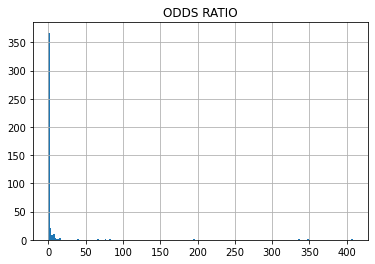

In [ ]:
# labor_practice_exp_risk_out_odds_ratios[labor_practice_exp_risk_out_odds_ratios['ODDS RATIO'] != -999][['ODDS RATIO']].hist(bins=200)

In [ ]:
import plotly.figure_factory as ff
import numpy as np

z = labor_practice_exp_risk_out_heatmap_values
z_text = np.around(labor_practice_exp_risk_out_heatmap_values, 2)

fig = ff.create_annotated_heatmap(z, x=risk_terms_lst_V2, y=labor_practice_terms_lst_V2, 
                                  annotation_text=z_text, colorscale='Viridis',
                                  hoverinfo='z')

# Make text size smaller
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 8

fig.show()

# Practice terms

**Method**:
- Query GDELT events for every term found in practice terms (i.e. querying 'contingent worker')
    - Store events, actor codes, event codes, and event code descriptions for each term


In [ ]:
# Practice terms
practice_terms = {'Practice': {'terms': ['discrimination', 'freelance', 'migrant', 'precarity', 'servitude', 
                                        'contingent worker', 'contract labor', 'contract worker', 
                                        'contractor labor', 'debt bondage', 'disrupt labor organiz',
                                        'factory turnover', 'forced labor', 'health safety',  # removed 'and' from 'health and safety'
                                        'labor broker', 'living income', 'living wage', 'modern slavery', 
                                        'overtime work', 'precarious work', 'prevent labor organiz',
                                        'recruitment fee', 'recruitment firm', 'union bust', 'wage theft', 'wage violation']
                               }
                  }

In [ ]:
# Load practice_terms_dfs
with open('practice_terms_dfs.pkl', 'rb') as f:
    practice_terms_dfs = pkl.load(f)
f.close()

#### Appendix: Saving data (Last saved 8/6)

In [ ]:
# # Save practice_terms_dfs
# practice_terms_dfs, practice_actor_codes_found, practice_event_codes_found = \
#     store_event_info_for_terms(terms_to_query=practice_terms, 
#                            type_of_term="Practice", 
#                            cameo_mapping=cameo_mapping, 
#                            limit=0, after_year='2010')

# with open('practice_terms_dfs.pkl', 'wb') as f:
#     pkl.dump(practice_terms_dfs, f, pkl.HIGHEST_PROTOCOL)
# f.close()

# DEI Practice terms

**Method**:
- Query GDELT events for every term found in DEI heuristics (i.e. querying 'diversity')
    - Store events, actor codes, event codes, and event code descriptions
    - Relevant context words from heuristics are used to query only a set of relevant articles for each DEI heuristic practice term (out all possible articles for the DEI heuristic practice term)

In [ ]:
relevant_context = ['women', 'female', 'minorit', 'color', 'ethnicit', 'race',
                    'racism', 'racial', 'sexual', 'orient', 'gender', 'disabili',
                    'veteran', 
                    # 'military veteran', 'protected veteran', 'veteran status' (just using veteran)
                    ]  

# Extra context for diversity
worker_context = ['worker', 'workforce', 'outreach', 'training']

# Extra context for whistleblower
primary_whistleblower_context = ['harass', 'wage', 'gender', 'sexual', 'race', 'racism', 'racial', 'minorit', 'women']
health_context = ['safety', 'unsafe', 'health']

dei_heuristic_to_term_mapping = {
    'Diversity': {'terms': ['divers', 'inclusi'], 
                  'relevant_context': relevant_context + worker_context},
    'Discrimination': {'terms': ['discriminat'], 
                       'relevant_context': relevant_context},
    'Harassment': {'terms': ['hostile work', 'harass', 'sexual'], 
                   'relevant_context': relevant_context},
    'Inclusion in hiring': {'terms': ['hire', 'hiring'], # Combined under "HIRE" after querying
                            'relevant_context': relevant_context},
    'Whistleblower': {'terms': ['whistleblower', 'anonymous', 'hotline', 'grievance'], 
                      'relevant_context': relevant_context + primary_whistleblower_context + health_context}

}

dei_practice_terms = [term 
                      for key, key_info in dei_heuristic_to_term_mapping.items()
                      for term in key_info.get('terms')]
print(dei_practice_terms)

['divers', 'inclusi', 'discriminat', 'hostile work', 'harass', 'sexual', 'hire', 'hiring', 'whistleblower', 'anonymous', 'hotline', 'grievance']


In [ ]:
# Load dei_practice_terms_dfs
# with open('dei_practice_terms_dfs.pkl', 'rb') as f:
#     dei_practice_terms_dfs = pkl.load(f)
# f.close()

In [ ]:
# dei_practice_terms_dfs['whistleblower']['df'].head(3)

,globaleventid,actor1code,actor1name,actor2code,actor2name,monthyear,year,quadclass,sourceurl,DEI Practice,Event code,Event code description
0,334274679,GOVCOP,INSPECTOR GENERAL,<NA>,<NA>,201501,2015,2,http://www.stripes.com/news/veterans/sen-tammy-baldwin-tells-va-to-interview-whistleblowers-1.326642,Whistleblower,090,Investigate- not specified below
1,253471923,GBR,UNITED KINGDOM,,<NA>,201304,2013,2,http://www.scotsman.com/news/health/nhs-staff-whistleblower-hotline-to-be-launched-1-2870780,Whistleblower,090,Investigate- not specified below
2,314587538,GOV,MINIST,<NA>,<NA>,201409,2014,2,http://www.independent.ie/irish-news/health/dail-public-accounts-committee-to-investigate-new-claims-by-garda-whistleblower-30596959.html,Whistleblower,090,Investigate- not specified below


#### Appendix: Saving data (last saved 8/6)

In [ ]:
# dei_practice_terms_dfs, dei_actor_codes_found, dei_event_codes_found = \
#     store_event_info_for_terms(terms_to_query=dei_heuristic_to_term_mapping, 
#                            type_of_term="DEI Practice", 
#                            cameo_mapping=cameo_mapping, 
#                            limit=0, after_year='2010')
    
# # Special cleaning (DEI practice terms) ##########################
# # 'hire' and 'hiring' to be combined under HIRE
# hire_info = dei_practice_terms_dfs['hire'].copy()
# hiring_info = dei_practice_terms_dfs['hiring'].copy()
# dei_practice_terms_dfs['hire']['df'] = dei_practice_terms_dfs['hire']['df'].append(hiring_info['df'], ignore_index=True)
# dei_practice_terms_dfs['hire']['actor_codes'] = sorted(list(set(hire_info['actor_codes'] + hiring_info['actor_codes'])))
# dei_practice_terms_dfs['hire']['event_codes'] = sorted(list(set(hire_info['event_codes'] + hiring_info['event_codes'])))
# del dei_practice_terms_dfs['hiring']

# # Save dei_practice_terms_dfs to pickle
# with open('dei_practice_terms_dfs.pkl', 'wb') as f:
#     pkl.dump(dei_practice_terms_dfs, f, pkl.HIGHEST_PROTOCOL)
# f.close()

In [ ]:
# for term, info in dei_practice_terms_dfs.items():
#     print(term, info['df'].shape[0])

## Risk terms

**Method**:
Exactly as method for practice terms. 

In [ ]:
# Risk terms
risk_terms = {'Risk': {'terms': ['boycott', 'compensation', 'delay', 
                                'detain', # detainment,  
                                'divestment', 'exclusion', 'fine', 
                                'impoundment', 'injury', 'lawsuit', 'litigation', 
                                'penalty', 'protest', 'reimbursement', 'restitution', 
                                'sanction', 'strike', 'monetary damage', 'operating costs', 'operational disruption', 
                                'share value', 'social license operate',  # removed 'to' from 'social license to operate'
                                'work stoppage',
                                 # Add "brand damage"
                                # 8/4: I. Shah suggestions
                                'employee turnover']
                       }
              }

In [ ]:
# Load risk_terms_dfs
with open('risk_terms_dfs.pkl', 'rb') as f:
    risk_terms_dfs = pkl.load(f)
f.close()

#### Appendix: Saving data (Last saved on 8/6)

In [ ]:
# # Save risk_terms_dfs
# risk_terms_dfs, risk_actor_codes_found, risk_event_codes_found = \
#     store_event_info_for_terms(terms_to_query=risk_terms, 
#                            type_of_term="Risk", 
#                            cameo_mapping=cameo_mapping, 
#                            limit=0, after_year='2010')
    
# with open('risk_terms_dfs.pkl', 'wb') as f:
#     pkl.dump(risk_terms_dfs, f, pkl.HIGHEST_PROTOCOL)
# f.close()

## Practice AND Risk Terms:

**Method**: 

*   Checking if risk terms are found within a) **URLs** and b) **event code descriptions** of practice term events, and vice versa.

Example: From all articles with URLs with the practice term "discrimination", in how many articles does their a) URL or b) event code description mention the risk term "boycott"?

*   Finding subset of "discrimination" articles containing "boycott"

**Current Focus (8/4)**:
*   Looking for risk terms within articles from DEI heuristic practice terms



**Eventual work TBD:**
- Separate all queried articles into the following three groups:


1.   Articles with Risk terms AND Practice terms
    * 8/2 - Analysis below: Finding percentages of practice term articles whose info contains a risk term, and vice versa.  
2.   Articles with Risk terms ONLY (no Practice terms)
    * All risk term articles MINUS risk term articles with practice terms
    * TBD
3.   Articles with Practice terms ONLY (no Risk terms)
    * All practice term articles MINUS practice term articles with risk terms
    * TBD



#### Functions (8/6):

In [ ]:
# Function to get type2 terms found in type1 term articles
def get_type2_term_occurrences_in_type1_articles(type_1_terms, type_2_terms,
                                                type_1_terms_dfs, 
                                                type_1='Practice', 
                                                type_2='Risk', type_1_category_col='DEI Practice'):
    """Returns dictionaries of the following:
    1) Events with type1 terms with at least 1 type2 term, by type1 term {'discriminat': pd.DataFrame()}
    2) Events with type1 terms with at least 1 type2 term, by type1 term category/heuristic {'Diversity': pd.DataFrame()}
    3) Events with type1 terms with at least 1 type2 term, by type1 term and type2 term {'discriminat': {'boycott': pd.DataFrame()}}
    
    :param type_1_terms: List of type_1_terms.
    :param type_2_terms: List of type_2_terms. 
    :param type_1_terms_dfs: Output from function store_event_info_for_terms(). 
    :param type_1: The type of terms whose articles we want to look for type_2 terms. Could be one of ['Practice', 'Risk', 'DEI Practice']. 
    :param type_2: The type of terms we are looking for in type_1 term articles. Could be one of ['Risk', 'Practice', 'DEI Practice'].
    :param type_1_category_col: Category of type 1 terms. Could be one of ['Risk', 'Practice', 'DEI Practice']. """

    print(f'(For every {type_1} term, searching its articles for {type_2} terms).')

    # Using keys instead of type_1_terms from list, in case events from certain terms were combined after querying
    # e.g.: 'hiring' events combined under 'hire' events
    columns_df = type_1_terms_dfs[list(type_1_terms_dfs.keys())[0]]['df'].columns
    type_1_term_category_ALL_type_2_occurrences = {category: pd.DataFrame(columns=columns_df)
                                                   for category in type_1_terms.keys()}
    # print(type_1_term_category_ALL_type_2_occurrences)                                     
    type_1_term_ALL_type_2_occurrences = {type_1_term: pd.DataFrame(columns=columns_df)
                                          for type_1_term in type_1_terms_dfs.keys()}
    type_1_term_individual_type_2_occurrences = {type_1_term: {type_2_term: pd.DataFrame(columns=columns_df)
                                                               for type_2_term in type_2_terms}
                                                 for type_1_term in type_1_terms_dfs.keys()}
    for type_1_term in type_1_terms_dfs.keys():
        term_events_df = type_1_terms_dfs[type_1_term]['df']
        print(f'Searching "{type_1_term}" events (count: {term_events_df.shape[0]})...')

        # Check each "practice term event" for risk terms (e.g. type_1 = practice, type_2 = risk)
        for idx, event_row in term_events_df.iterrows():
            type_1_event_url = event_row['sourceurl']
            type_1_event_code_desc = event_row['Event code description']
            type_1_category = event_row[type_1_category_col]
            # print(type_1_category)

            for type_2_term in type_2_terms:
                type_2_term_FOUND = False
                type_2_term_words = type_2_term.split(' ')

                if len(type_2_term_words) == 3:
                    type_2_term_word_count = 0
                    for word in type_2_term_words:
                        if (word in type_1_event_url) or (word in type_1_event_code_desc):
                            type_2_term_word_count += 1
                    if type_2_term_word_count == len(type_2_term_words):
                        type_2_term_FOUND = True

                elif len(type_2_term_words) == 2:
                    # Generate regex to find multi-word term in article URL or event description
                    # Doing this to avoid the following situation:
                    # term = "share value", article queried has phrase "shared values"
                    regex = r"(?i)^"
                    for word in type_2_term_words:
                        regex += r"(?=.*\b{}\b)".format(word)
                    regex += r".*$"
                    if len(re.findall(regex, type_1_event_url)) > 1 or len(
                            re.findall(regex, type_1_event_code_desc)) > 1:
                        type_2_term_FOUND = True
                        print(f'REGEX CHECK: risk term = "{type_2_term}", regex = {regex}')
                        print(f'event URL: {type_1_event_url}')
                        print(f'event code description: {type_1_event_code_desc}')

                elif len(type_2_term_words) == 1:
                    if type_2_term in type_1_event_url or type_1_event_url in type_1_event_code_desc:
                        type_2_term_FOUND = True

                if type_2_term_FOUND:
                    type_1_term_category_ALL_type_2_occurrences[type_1_category] = type_1_term_category_ALL_type_2_occurrences[type_1_category].append(event_row, ignore_index=True)
                    type_1_term_ALL_type_2_occurrences[type_1_term] = type_1_term_ALL_type_2_occurrences[
                        type_1_term].append(event_row, ignore_index=True)
                    type_1_term_individual_type_2_occurrences[type_1_term][type_2_term] = \
                    type_1_term_individual_type_2_occurrences[type_1_term][type_2_term].append(event_row,
                                                                                               ignore_index=True)

    # Drop duplicates
    for type_1_category, df in type_1_term_category_ALL_type_2_occurrences.items():
        df.drop_duplicates(subset='sourceurl', keep="last", inplace=True)
    for type_1_term, df in type_1_term_ALL_type_2_occurrences.items():
        df.drop_duplicates(subset='sourceurl', keep="last", inplace=True)
    return type_1_term_category_ALL_type_2_occurrences, type_1_term_ALL_type_2_occurrences, type_1_term_individual_type_2_occurrences

In [ ]:
dei_heuristic_ANY_risk_dfs, dei_practice_events_ANY_risk_dfs, dei_practice_events_by_risk_term_dfs = get_type2_term_occurrences_in_type1_articles(
    type_1_terms=dei_heuristic_to_term_mapping,
    type_2_terms=risk_terms['Risk']['terms'], 
    type_1_terms_dfs=dei_practice_terms_dfs, 
    type_1='DEI Practice', type_2='Risk')

Generating mapping for Risk terms found in DEI Practice articles...
(For every DEI Practice term, search its article info for Risk terms).
Searching "divers" events (count: 10715)...
Searching "inclusi" events (count: 4632)...
Searching "discriminat" events (count: 17085)...
Searching "hostile work" events (count: 114)...
Searching "harass" events (count: 45879)...
Searching "sexual" events (count: 331759)...
Searching "hire" events (count: 19417)...
Searching "whistleblower" events (count: 1590)...
Searching "anonymous" events (count: 1296)...
Searching "hotline" events (count: 1266)...
Searching "grievance" events (count: 291)...


In [ ]:
dei_practice_events_ANY_risk_dfs.keys()

dict_keys(['divers', 'inclusi', 'discriminat', 'hostile work', 'harass', 'sexual', 'hire', 'whistleblower', 'anonymous', 'hotline', 'grievance'])

In [ ]:
dei_practice_events_ANY_risk_summary = pd.DataFrame(
    columns=['DEI Heuristic', 'DEI Practice term', 
             'Count of Practice term events', 
             'Count of Practice term events with ANY Risk term', 
             'Count of Practice term events with NO Risk term',
             '% Practice term events with ANY Risk term',
             '% Practice term events with NO Risk term'])

for dei_practice_term, events_df in dei_practice_events_ANY_risk_dfs.items():
    count_events_with_practice = dei_practice_terms_dfs[dei_practice_term]['df'].shape[0]
    count_events_with_practice_and_risk = events_df.shape[0]
    count_events_with_NO_risk = count_events_with_practice - count_events_with_practice_and_risk
    summary_row = {
        'DEI Heuristic': events_df['DEI Practice'].values[0],
        'DEI Practice term': dei_practice_term,
        'Count of Practice term events': count_events_with_practice,
        'Count of Practice term events with ANY Risk term': count_events_with_practice_and_risk,
        'Count of Practice term events with NO Risk term': count_events_with_NO_risk,
        '% Practice term events with ANY Risk term': count_events_with_practice_and_risk / count_events_with_practice * 100,
        '% Practice term events with NO Risk term': count_events_with_NO_risk / count_events_with_practice * 100

    }
    dei_practice_events_ANY_risk_summary = dei_practice_events_ANY_risk_summary.append(summary_row, ignore_index=True)

In [ ]:
dei_practice_events_ANY_risk_summary.sort_values(by='% Practice term events with ANY Risk term', ascending=False)

,DEI Heuristic,DEI Practice term,Count of Practice term events,Count of Practice term events with ANY Risk term,Count of Practice term events with NO Risk term,% Practice term events with ANY Risk term,% Practice term events with NO Risk term
3,Harassment,hostile work,114,22,92,19.298246,80.701754
2,Discrimination,discriminat,17085,1765,15320,10.330699,89.669301
7,Whistleblower,whistleblower,1590,95,1495,5.974843,94.025157
10,Whistleblower,grievance,291,17,274,5.841924,94.158076
4,Harassment,harass,45879,2456,43423,5.353212,94.646788
5,Harassment,sexual,331759,8767,322992,2.642581,97.357419
6,Inclusion in hiring,hire,19417,350,19067,1.802544,98.197456
0,Diversity,divers,10715,157,10558,1.465236,98.534764
1,Diversity,inclusi,4632,57,4575,1.230570,98.769430
8,Whistleblower,anonymous,1296,15,1281,1.157407,98.842593


In [ ]:
dei_practice_events_ANY_risk_dfs.keys()

dict_keys(['divers', 'inclusi', 'discriminat', 'hostile work', 'harass', 'sexual', 'hire', 'whistleblower', 'anonymous', 'hotline', 'grievance'])

In [ ]:
# By practice term
import plotly.graph_objects as go

practice_term = 'divers'
year_practice_term_summary = dei_practice_events_ANY_risk_dfs[practice_term][['globaleventid', 'year']].groupby('year').agg('count').rename(columns={'globaleventid': 'Event count'}).reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=year_practice_term_summary['year'], y=year_practice_term_summary['Event count'],
                    mode='lines+markers',
                    name='lines+markers'))

fig.update_layout(title=f'"{practice_term}" Events with any Risk term',
                   xaxis_title='Year',
                   yaxis_title='Event count')

fig.show()

# Come up with list of baselines for each year (Ipek advice)

In [ ]:
year_practice_term_summary

,year,Event count
0,2013,2
1,2014,10
2,2015,10
3,2016,23
4,2017,25
5,2018,16
6,2019,27
7,2020,26
8,2021,18


In [ ]:
dei_heuristic_to_term_mapping.keys()

dict_keys(['Diversity', 'Discrimination', 'Harassment', 'Inclusion in hiring', 'Whistleblower'])

In [ ]:
dei_heuristic_ANY_risk_dfs['Whistleblower'][['globaleventid', 'year']].groupby('year').agg('count').rename(columns={'globaleventid': 'Event count'})


,Event count
year,
2013,5
2014,7
2015,15
2016,16
2017,23
2018,21
2019,11
2020,26
2021,9


In [ ]:
import plotly.graph_objects as go

heuristic = 'Harassment'
year_heuristic_summary = dei_heuristic_ANY_risk_dfs[heuristic][['globaleventid', 'year']].groupby('year').agg('count').rename(columns={'globaleventid': 'Event count'}).reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=year_heuristic_summary['year'], y=year_heuristic_summary['Event count'],
                    mode='lines+markers',
                    name='lines+markers'))

fig.update_layout(title=f'"{heuristic}" Events with any Risk term',
                   xaxis_title='Year',
                   yaxis_title='Event count')

fig.show()

# Come up with list of baselines for each year (Ipek advice)

In [ ]:
# dei_practice_events_ANY_risk_dfs['divers'].head(2)

In [ ]:
# year_range = (2010, 2021)
# dei_practice_events_ANY_risk_dfs_BY_YEAR = {dei_practice_term: {year: events_df[events_df['year'] == year] 
#                                                                 for year in year_range} 
#                                             for dei_practice_term, events_df in dei_practice_events_ANY_risk_dfs.items()}

In [ ]:
dei_practice_events_BY_risk_summary = pd.DataFrame(
    columns=['DEI Heuristic', 'DEI Practice term', 'Risk term',
             'Count of Practice term events with Risk term', 
             # 'Count of Practice term events without Risk term', 
             '% Practice term events with Risk term',
             # '% Practice term events without Risk term'
             'Count of Practice term events', 
             ])

for dei_practice_term, risk_term_info in dei_practice_events_by_risk_term_dfs.items():
    count_of_practice_term_events = dei_practice_events_ANY_risk_summary[dei_practice_events_ANY_risk_summary['DEI Practice term'] == dei_practice_term][['Count of Practice term events']].values[0][0]
    
    for risk_term, risk_term_events_df in risk_term_info.items():
        count_of_risk_term_events_for_practice = risk_term_events_df.shape[0]
        
        summary_row = {
            'DEI Heuristic': risk_term_events_df['DEI Practice'].values[0],
            'DEI Practice term': dei_practice_term,
            'Risk term': risk_term,
            'Count of Practice term events with Risk term': count_of_risk_term_events_for_practice, 
            '% Practice term events with Risk term': count_of_risk_term_events_for_practice / count_of_practice_term_events * 100,
            'Count of Practice term events': count_of_practice_term_events
        }

        dei_practice_events_BY_risk_summary = dei_practice_events_BY_risk_summary.append(summary_row, ignore_index=True)

NameError: ignored

In [ ]:
dei_practice_events_BY_risk_summary

,DEI Heuristic,DEI Practice term,Risk term,Count of Practice term events with Risk term,% Practice term events with Risk term,Count of Practice term events
0,Whistleblower,divers,boycott,9,0.083994,10715
1,Whistleblower,divers,compensation,3,0.027998,10715
2,Whistleblower,divers,delay,11,0.102660,10715
3,Whistleblower,divers,detain,0,0.000000,10715
4,Whistleblower,divers,divestment,0,0.000000,10715
5,Whistleblower,divers,exclusion,0,0.000000,10715
6,Whistleblower,divers,fine,23,0.214652,10715
7,Whistleblower,divers,impoundment,0,0.000000,10715
8,Whistleblower,divers,injury,0,0.000000,10715
9,Whistleblower,divers,lawsuit,40,0.373308,10715


In [ ]:
dei_events_with_risk_summary = pd.read_csv('dei_events_with_risk_summary.csv.gz', low_memory=False)

In [ ]:
dei_events_with_risk_summary.head(1)

,DEI Practice term,DEI Practice term articles,Risk term,Risk term occurences in DEI Practice term articles,% Risk term occurences in DEI Practice term articles,Event codes,Actor codes,DEI Heuristic
0,diverse,1135,boycott,1,0.088106,163,MED,Diversity


#### Work:

**Risk terms found in DEI practice term articles (8/4: Ran and saved everything)**

Things to do:
- Add actor codes to this table (DONE)
- Add heuristic column for DEI practice term (DONE)
- Add functionality to admit similar words ("racial OR race OR racism")
- Based on 8/2 feedback on general practice/risk terms:
   - (DEI) Practice term vs ANY risk term (aggregation of all risk term occurences within a single practice term?)
- Start odds ratio code / wait for Alex's code

#### Appendix: Saving data

In [ ]:
# dei_events_with_risk_dict = get_type2_term_occurences_in_type1_articles(type_1_terms=dei_practice_terms, 
#                                             type_2_terms=risk_terms, 
#                                             type_1_term_dfs=dei_practice_terms_dfs, 
#                                             type_1='DEI Practice', 
#                                             type_2='Risk')

# # dei_events_with_risk_dict['hostile work']['lawsuit']['df'].head()

# dei_events_with_risk_df = get_cooccuring_events_info_df(events_dict=dei_events_with_risk_dict, 
#                               type_1_terms_dfs=dei_practice_terms_dfs, 
#                               type_1='DEI Practice', 
#                               type_2='Risk', dei_heuristic_col=True)
# dei_events_with_risk_df.to_csv('dei_events_with_risk_summary.csv.gz', index=False, compression='gzip')

Generating mapping for Risk terms found in DEI Practice articles...
(For every DEI Practice term, search its article info for Risk terms).


In [ ]:
# 8/6 TODO? (Based on 8/2 feedback): For each DEI practice term, aggregate numbers by all risk terms 
    

#### Summaries (8/5)

In [ ]:
dei_events_with_risk_df = pd.read_csv('dei_events_with_risk_summary.csv.gz', low_memory=False)
dei_events_with_risk_df = dei_events_with_risk_df[['DEI Heuristic', 'DEI Practice term', 'DEI Practice term articles', 'Risk term',
       'Risk term occurences in DEI Practice term articles',
       '% Risk term occurences in DEI Practice term articles', 'Event codes',
       'Actor codes']]

In [ ]:
dei_events_with_risk_df.sort_values(by='% Risk term occurences in DEI Practice term articles', ascending=False).head(10)

DEI Heuristic DEI Practice term  DEI Practice term articles Risk term  \
135      Harassment      hostile work                         112   lawsuit   
110  Discrimination       discriminat                       16702   lawsuit   
178      Harassment            sexual                      331759    detain   
360   Whistleblower     whistleblower                         360   lawsuit   
353   Whistleblower     whistleblower                         360    detain   
116  Discrimination       discriminat                       16702  sanction   
153      Harassment            harass                       45743    detain   
103  Discrimination       discriminat                       16702    detain   
278   Whistleblower            safety                        7348    detain   
160      Harassment            harass                       45743   lawsuit   

     Risk term occurences in DEI Practice term articles  \
135                                                  20   
110                                                1876   
178                                               34435   
360                                                  30   
353                                                  24   
116                                                 943   
153                                                2467   
103                                                 870   
278                                                 346   
160                                                2097   

     % Risk term occurences in DEI Practice term articles  \
135                                             17.857143   
110                                             11.232188   
178                                             10.379522   
360                                              8.333333   
353                                              6.666667   
116                                              5.646030   
153                                              5.393175   
103                                              5.208957   
278                                              4.708764   
160                                              4.584308   

                                                                                                                                                                                                                                                                                     Event codes  \
135                                                                                                                                                                                                                                                 010|020|042|043|051|080|0831|105|112|114|115   
110                      010|011|012|013|014|016|020|0214|022|0231|026|030|032|033|035|036|037|040|042|043|045|046|050|051|052|057|060|070|071|072|080|081|0831|084|0841|0874|090|100|1043|110|111|112|114|115|120|124|125|127|128|130|131|1312|138|141|143|160|164|172|173|180|1821|190|192|193   
178                                                                                                                         010|011|012|013|014|016|020|030|036|040|042|043|046|051|060|080|084|0841|090|100|1014|110|111|112|1123|114|115|120|130|140|142|172|173|175|180|1821|1822|190|191|193   
360                                                                                                                                                                                                                                  010|012|020|040|043|052|060|081|090|110|112|115|143|173|190   
353                                                                                                                                                                                                                                                                              010|020|114|173   
116                                                           

In [ ]:
dei_events_with_risk_df[dei_events_with_risk_df['DEI Heuristic'] == 'Diversity'].sort_values(by='% Risk term occurences in DEI Practice term articles', ascending=False).head(10)

,DEI Heuristic,DEI Practice term,DEI Practice term articles,Risk term,Risk term occurences in DEI Practice term articles,% Risk term occurences in DEI Practice term articles,Event codes,Actor codes
91,Diversity,inclusive,1514,sanction,33,2.179657,081|1312|163|172,|BUS|CHR|CHRPRO230|EDU|FRA|FRAGOV|GBRSPY|GOV|LAB|LEG|MIL|MNCUSAHLH|NGOHRI|REL|SSD|USA|USAEDU|USAGOV|USAMED|VNM
41,Diversity,diversity,6012,sanction,122,2.029275,012|081|1312|163|172,|AFR|ARM|BLR|BLZ|BRA|BUS|CAN|CHN|CHRPRO|CRM|CVL|EDU|EDUGOV|ELI|FRA|GBR|GOV|GOVMIL|IGOEURCOE|ISR|ITA|JUD|KOR|LAB|LEG|MDV|MIL|MNCCAN|MNCUSA|MOS|MYS|SLB|SOM|URY|USA|USACVL|USAEDU|USAELI|USAGOV|USALEG|USAMIL
16,Diversity,diverse,1135,sanction,20,1.762115,081|163|172,CAN|COP|CVL|EDU|ELI|GBRGOV|GOV|HLH|JEW|JUD|LEG|LUX|MDV|MED|USA
53,Diversity,inclusion,2048,detain,36,1.757812,173,AIAELI|ARE|BHS|BUS|CAN|CHL|CHN|COP|COPGOV|CVL|EDU|ESP|GBR|GOV|IRQ|ISR|JUD|LAB|LBN|LBR|LEG|MYSLEG|NGA|NGOUSA|NLD|OPP|PAK|PAKLEG|POL|RWA|SLE|TZA|TZACHR|USA|USAGOV
3,Diversity,diverse,1135,detain,17,1.497797,173,AUS|AUSMED|CHRPRO|CHRPRO210|COP|CVL|GBR|GOV|JUD|LAB|MIL|NLD|NOR|USA|USAGOV|nai
28,Diversity,diversity,6012,detain,88,1.463739,173,AFR|AUS|BUS|BUSJUD|CAN|CHN|COP|CRM|CVL|DEUBUS|EDU|ENV|GBR|GOV|GRC|HLH|HND|IND|ITA|JEW|JPN|JUD|KEN|KOR|LAB|LEG|MCOELI|MED|MEX|MILCOP|MNCGBRGOV|MNCUSA|MNCUSAHLH|MNCUSAMED|MNG|MYS|NGOBUSWEF|NLD|OPP|POL|RAD|REL|RUS|RWA|SGP|THAREL|USA|USACVL|USAELI|USAJUD|USAMED|ZAFELI|idgGOV|uig|uigCVL
78,Diversity,inclusive,1514,detain,22,1.453104,173,AFR|AUT|BUS|CHR|CHRCTH|COP|CRM|CRMJUD|CVL|EDU|FRA|GBR|GHA|GOV|IGOEURSCE|IND|JEW|LAB|LEG|MED|PTY|USA|ZAF
66,Diversity,inclusion,2048,sanction,20,0.976562,081|172,BUS|CHN|CHREDU|CHRPRO|EDU|ETH|GOV|ISR|MIL|MNCUSAHLH|OPP|USA|USAEDU|USAGOV|USALEG|USAMIL
13,Diversity,diverse,1135,protest,8,0.704846,012|036|133|141|190,COP|CVL|GOV|ITA|MMR|USA|USAMED|VNM
38,Diversity,diversity,6012,protest,37,0.615436,010|033|040|042|051|100|110|111|114|120|130|133|140|141|164|190|192|193,AFR|BEL|BRA|BUS|CAN|CHRPRO|COP|CVL|EDU|GBR|GOV|MEX|NZL|OPP|PAK|SIK|USA|USACOP|USAEDU|USAGOV


In [ ]:
# Run after 8/6 meeting
dei_events_with_any_risk_term_dict = get_aggregate_type1_term_total_articles_with_type2_terms(
    type_1_terms=dei_practice_terms, type_2_terms=risk_terms, 
    type_1_terms_dfs=dei_practice_terms_dfs, type_1='DEI Practice', type_2='Risk')

NameError: ignored

In [ ]:
# for dei_practice_term, events_with_risk_term_df in dei_events_with_any_risk_term_dict.items():
#     print(dei_practice_term, events_with_risk_term_df.shape[0])

In [ ]:
# For each heuristic's practice term articles (containing a risk term), look into most common event codes
# Look at 2-3 examples of articles from each event code ()

In [ ]:
for term in dei_practice_terms:
    term_df = dei_events_with_risk_df[dei_events_with_risk_df['DEI Practice term'] == term]
    term_article_count = term_df['DEI Practice term articles'].values[0]
    # For all articles of a term, need to do an OR on each of the risk terms to get the aggregate 
    # Otherwise, we could potentially count duplicates (articles with more than one risk term)

**DEI practice terms found in Risk term articles (8/6: Running everything)**

In [ ]:
# risk_events_with_dei_practice_dict = get_type2_term_occurences_in_type1_articles(type_1_terms=risk_terms, 
#                                             type_2_terms=dei_practice_terms, 
#                                             type_1_term_dfs=risk_terms_dfs, 
#                                             type_1='Risk', 
#                                             type_2='DEI Practice')

# risk_events_with_dei_practice_df = get_cooccuring_events_info_df(events_dict=risk_events_with_dei_practice_dict, 
#                               type_1_terms_dfs=risk_terms_dfs, 
#                               type_1='Risk', 
#                               type_2='DEI Practice')

# risk_events_with_dei_practice_df.to_csv('risk_events_with_dei_practice_summary.csv.gz', index=False, compression='gzip')

In [ ]:
risk_events_with_dei_practice_df = pd.read_csv('risk_events_with_dei_practice_summary.csv.gz', low_memory=False)

In [ ]:
risk_events_with_dei_practice_df.sort_values(by='% DEI Practice term occurences in Risk term articles', ascending=False).head(10)

**Risk terms found in practice term articles (8/6: Running everything) (this contributes to Article Group 1, as defined above)**

In [ ]:
# practice_events_with_risk_dict = get_type2_term_occurences_in_type1_articles(type_1_terms=practice_terms, 
#                                             type_2_terms=risk_terms, 
#                                             type_1_term_dfs=practice_terms_dfs, 
#                                             type_1='Practice', 
#                                             type_2='Risk')

# practice_events_with_risk_df = get_cooccuring_events_info_df(events_dict=practice_events_with_risk_dict, 
#                               type_1_terms_dfs=practice_terms_dfs, 
#                               type_1='Practice', 
#                               type_2='Risk')

# practice_events_with_risk_df.to_csv('practice_events_with_risk_summary.csv.gz', index=False, compression='gzip')


In [ ]:
practice_events_with_risk_df = pd.read_csv('practice_events_with_risk_summary.csv.gz', low_memory=False)

In [ ]:
practice_events_with_risk_df.sort_values(by='% Risk term occurences in Practice term articles', ascending=False).head(10)
# Can odds ratio be used with this analysis?
# 8/2: Practice term vs ANY risk term (aggregation of all risk term occurences)

**Practice terms found in risk term articles (8/6: Running everything) (this contributes to Article Group 1, as defined above)**

In [ ]:
risk_events_with_practice_dict = get_type2_term_occurences_in_type1_articles(type_1_terms=risk_terms, 
                                            type_2_terms=practice_terms, 
                                            type_1_term_dfs=risk_terms_dfs, 
                                            type_1='Risk', 
                                            type_2='Practice')

risk_events_with_practice_df = get_cooccuring_events_info_df(events_dict=risk_events_with_practice_dict, 
                              type_1_terms_dfs=risk_terms_dfs, 
                              type_1='Risk', 
                              type_2='Practice')

risk_events_with_practice_df.to_csv('risk_events_with_practice_summary.csv.gz', index=False, compression='gzip')

risk_events_with_practice_df.sort_values(by='% Practice term occurences in Risk term articles', ascending=False).head(10)
# Can odds ratio be used with this analysis?
# 8/2: Practice term vs ANY risk term (aggregation of all risk term occurences)

In [ ]:
# risk_practice_info_df.sort_values(by='% Practice term occurences in risk term articles', ascending=False).head(10)
# # Can odds ratio be used with this analysis?

In [ ]:
# events_with_risk_and_practice_terms = {risk_term: dict() for risk_term in risk_terms_dfs.keys()}

# # Iterate over risk terms first
# for risk_term in risk_terms:
#     df_risk_term = risk_terms_dfs[risk_term]['df']

#     for practice_term in practice_terms:
#         risk_prac_common_df = pd.DataFrame(columns=list(df_risk_term.columns))

#         # Check each "risk term event" for practice terms
#         for index, event_row in df_risk_term.iterrows():
#             risk_event_url = event_row['sourceurl']
#             risk_event_code_desc = event_row['Event code description']
#             practice_term_words = practice_term.split(' ')
#             practice_term_word_count = 0
#             for word in practice_term_words:
#                 if (word in risk_event_url) or (word in risk_event_code_desc):
#                     practice_term_word_count += 1
#             if practice_term_word_count == len(practice_term_words): 
#                 risk_prac_common_df = risk_prac_common_df.append(event_row, ignore_index=True)

#         events_with_risk_and_practice_terms[risk_term][practice_term] = {}
#         events_with_risk_and_practice_terms[risk_term][practice_term]['df'] = risk_prac_common_df
#         events_with_risk_and_practice_terms[risk_term][practice_term]['event_codes'] = risk_prac_common_df['Event code'].unique()

In [ ]:
# risk_practice_info_df = pd.DataFrame(columns=['Risk term', 'Risk term articles', 'Practice term', 
#                                               # 'Practice term articles',  
#                                               'Practice term occurences in risk term articles', 
#                                               '% Practice term occurences in risk term articles',
#                                               'Event codes'])

# for risk_term, practice_term_info in events_with_risk_and_practice_terms.items():
#     risk_term_article_count = risk_terms_dfs[risk_term]['df'].shape[0]

#     for practice_term, df_and_event_codes in practice_term_info.items():
#         # practice_term_article_count = practice_terms_dfs[practice_term]['df'].shape[0]

#         row = {'Risk term': risk_term, 
#                'Risk term articles': risk_term_article_count, 
#                'Practice term': practice_term, 
#                # 'Practice term articles': practice_term_article_count, 
#                'Practice term occurences in risk term articles': df_and_event_codes['df'].shape[0], 
#                '% Practice term occurences in risk term articles': df_and_event_codes['df'].shape[0] / risk_term_article_count * 100, 
#                'Event codes': ', '.join(sorted(df_and_event_codes['event_codes']))}
#         risk_practice_info_df = risk_practice_info_df.append(row, ignore_index=True)


**Next steps (as of 8/2):**

0.   Incorporate feedback from 8/2 meeting
    *   Observe event code frequencies for articles of a specific practice/risk term (can do it by full event code, or just event base code)
    *   Add actor1code, actor2code, and actor1type(1/2/3)code to output datasets (to evaluate in the same ways as event codes for different practice/risk terms) (**IN PROGRESS**, need to add to later analyses)
    *   Get actor code mappings and merge with datasets (**DONE** in Appendix)
    *   For now, not removing any events based on actor codes, but some to consider for filtering events out include: COP, SEP, MIL, UAF.

0.   **Query for events from DEI heuristic terms (these would count as practice terms** (8/4: Marked as priority 1)
1.   **Create pipeline to generate co-occurence matrices using odds ratio** (8/4: Marked as priority 2)
2.   Research PMI (point-wise mutual information) metric for comparing practice term and risk term articles
3.   Create pipeline for PMI work
4.   Query for more articles (go beyond limit=10000 per term)



# Appendix:

In [ ]:
url_distinct_counts_query = """
    SELECT COUNT(DISTINCT sourceurl) AS count_url 
    FROM `cdpdemo.gdelt_demo.gdelt_events`
"""
url_distinct_counts = redivis.query(url_distinct_counts_query).to_dataframe()

In [ ]:
url_distinct_counts

,count_url
0,103522599


## Map event codes to CAMEO descriptions

In [ ]:
# Map event codes to CAMEO descriptions
# CSV is messy (commas in text fields without surrounding quotes, will save a cleaned version)

import csv

# Get file downloaded from here (on 7/30/2021), saved to Drive:
# https://raw.githubusercontent.com/tenthe/CAMEO-Event-Data-Codebook/master/cameo.csv

# to get the id part of the file
cameo_filepath_download_drive = 'https://drive.google.com/file/d/1wqepp0cnynV7GXweDpAWbfsTVBzYrxmr'
id = cameo_filepath_download_drive.split("/")[-1]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('event-codes-CAMEO-Event-Data-Codebook.csv')  
  
infile = open("event-codes-CAMEO-Event-Data-Codebook.csv", "r", encoding='utf-8')
outfile = open("/content/drive/MyDrive/Rights Colab RK/cleaned-cameo-event-code-mapping.csv", "w", encoding='utf-8')

reader = csv.reader(infile)
writer = csv.writer(outfile)
for line in reader:
    if len(line[1:]) > 1:
        text_col = ','.join(line[1:])
    else:
        text_col = line[1]
    new_line = line[0] + '|' + text_col
    new_line_lst = new_line.split('|')
    writer.writerow(new_line_lst)

infile.close()
outfile.close()

## Match practice terms and risk terms to event codes
**Conclusion**:

*   **Practice terms**: **0 (zero) event codes** containing descriptions that explicitly match words in practice terms
*   **Risk terms**: **46 event codes** containing descriptions that explicitly match words in risk terms
    *   *Boycott, detain, lawsuit, protest, sanction, strike, share value*
    *   We can use these event codes to query for more articles surrounding the above risk terms, without explicitly using the risk terms in the SQL queries
    * **Questions to look into**:

        1.   What to do about event codes containing more than one risk term? (see below for "boycott") 







In [ ]:
# Find event codes that match with practice and risk terms
# Add these event codes to dictionary
# Example:
# {'discrimination': [111, 222, 333]}

In [ ]:
cameo_mapping_lc = cameo_mapping.copy()
cameo_mapping_lc['Event code description'] = cameo_mapping_lc['Event code description'].str.lower()
cameo_mapping_lc.head()

,Event code,Event code description
0,01,make public statement
1,010,make statement- not specified below
2,011,decline comment
3,012,make pessimistic comment
4,013,make optimistic comment


In [ ]:
singular_word_practice_terms = ['discrimination', 'freelance', 'migrant', 'precarity', 'servitude']

multiple_word_practice_terms = ['contingent worker', 'contract labor', 'contract worker', 
                  'contractor labor', 'debt bondage', 'disrupt labor organiz',
                  'factory turnover', 'forced labor', 'health safety', # removed 'and' from 'health and safety'
                  'labor broker', 'living income', 'living wage', 'modern slavery', 
                  'overtime work', 'precarious work', 'prevent labor organiz',
                  'recruitment fee', 'recruitment firm', 'union bust', 'wage theft', 'wage violation'
                  ]

practice_term_event_codes = {}
for practice_term in singular_word_practice_terms:
    practice_term_event_codes[practice_term] = cameo_mapping_lc[cameo_mapping_lc['Event code description'].str.contains(practice_term)]

for practice_term in multiple_word_practice_terms:
    for word in practice_term.split():
        codes_containing_word = cameo_mapping_lc[cameo_mapping_lc['Event code description'].str.contains(word)]
        if practice_term not in practice_term_event_codes:
            practice_term_event_codes[practice_term] = codes_containing_word
        else:
            practice_term_event_codes[practice_term].append(codes_containing_word, ignore_index=True)

for term, df in practice_term_event_codes.items():
    print(term, df.shape[0])

discrimination 0
freelance 0
migrant 0
precarity 0
servitude 0
contingent worker 0
contract labor 0
contract worker 0
contractor labor 0
debt bondage 0
disrupt labor organiz 0
factory turnover 0
forced labor 0
health safety 0
labor broker 0
living income 0
living wage 0
modern slavery 0
overtime work 0
precarious work 0
prevent labor organiz 0
recruitment fee 0
recruitment firm 0
union bust 0
wage theft 0
wage violation 0


In [ ]:
singular_word_risk_terms = ['boycott', 'compensation', 'delay', 'detain', 
                            'detainment', 'divestment', 'exclusion', 'fine', 
                            'impoundment', 'injury', 'lawsuit', 'litigation', 
                            'penalty', 'protest', 'reimbursement', 'restitution', 
                            'sanction', 'strike']

multiple_word_risk_terms = ['monetary damage', 'operating costs', 'operational disruption', 
                            'share value', 'social license operate',  # removed 'to' from 'social license to operate'
                            'work stoppage']

risk_term_event_codes = {}
for risk_term in singular_word_risk_terms:
    risk_term_event_codes[risk_term] = cameo_mapping_lc[cameo_mapping_lc['Event code description'].str.contains(risk_term)]

for risk_term in multiple_word_risk_terms:
    for word in risk_term.split():
        codes_containing_word = cameo_mapping_lc[cameo_mapping_lc['Event code description'].str.contains(word)]
        if risk_term not in risk_term_event_codes:
            risk_term_event_codes[risk_term] = codes_containing_word
        else:
            risk_term_event_codes[risk_term].append(codes_containing_word, ignore_index=True)

for term, df in risk_term_event_codes.items():
    print(term, df.shape[0])

boycott 12
compensation 0
delay 0
detain 1
detainment 0
divestment 0
exclusion 0
fine 0
impoundment 0
injury 0
lawsuit 1
litigation 0
penalty 0
protest 7
reimbursement 0
restitution 0
sanction 14
strike 10
monetary damage 0
operating costs 0
operational disruption 0
share value 1
social license operate 0
work stoppage 0


In [ ]:
risk_term_event_codes['boycott']
# What to do about multiple risk terms in event code, if we want to query by event code? Is this a good idea then?

# Filter out...
# actor1type = GOV + strike or lawsuit in event code -- DROP (this combo can be related to embargo or sanction, not interested)

,Event code,Event code description
33,0254,"appeal for easing of economic sanctions, boycott, or embargo"
61,0354,"express intent to ease economic sanctions, boycott, or embargo"
114,085,"ease economic sanctions, boycott, embargo"
152,1054,"demand easing of economic sanctions, boycott, or embargo"
190,1244,"refuse to ease economic sanctions, boycott, or embargo"
202,1312,"threaten with sanctions, boycott, embargo"
233,143,conduct strike or boycott- not specified below
234,1431,conduct strike or boycott for leadership change
235,1432,conduct strike or boycott for policy change
236,1433,conduct strike or boycott for rights


## CAMEO code descriptions for Actor codes

In [ ]:
pip install tabula-py

     |████████████████████████████████| 11.7 MB 7.7 MB/s 


In [ ]:
import tabula

In [ ]:
!ls "/content/drive/MyDrive/Rights Colab RK"

CAMEO.Manual.1.1b3.pdf			   gdelt_explore.ipynb
cleaned-cameo-event-code-mapping.csv	   gdelt-risk-practice.ipynb
event-codes-CAMEO-Event-Data-Codebook.csv  RK


In [ ]:
# Get file downloaded from here (on 8/2/2021), saved to Drive:
# http://data.gdeltproject.org/documentation/CAMEO.Manual.1.1b3.pdf

# to get the id part of the file
cameo_pdf_download_drive = 'https://drive.google.com/file/d/1sQNBr5YsYzjPP4SGjwDuS63BoS4UySdB'
id = cameo_pdf_download_drive.split("/")[-1]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('CAMEO.Manual.1.1b3.pdf')  

In [ ]:
cameo_doc = "CAMEO.Manual.1.1b3.pdf"

actor_codebook_page_mapping = {
    'Generic Domestic Role Codes': [100],
    'International/Transnational Generic Codes': [104],
    'International Region Codes': [105],
    'International/Transnational Actors with Special Codes': [107, 108],
    'Religious Codes: First Three Letters': [114],
    'Religious Codes: Second Three Letters': [115],
    'CAMEO Ethnic Group Codes': [121, 137],  # range from 121 to 137
}

actor_code_tables = {}
for table_name, page_range in actor_codebook_page_mapping.items():
    if len(page_range) == 1:
        pages_param = page_range[0]
    else:
        pages_param = (str(page_range[0])+'-'+str(page_range[1]))
    actor_code_tables[table_name] = tabula.read_pdf(cameo_doc, pages=pages_param, encoding='utf-8', silent=True)


In [ ]:
# Pre-processing TBD:
# Remove special characters (\r), replace with space
# First table: If there is a NaN in the next row, perform row merge with current row and next row


In [ ]:
# dei_heuristic_to_term_mapping = {
#     'Diversity': ['divers', 'inclusi'],
#     'Discrimination': ['discriminat'],
#     'Harassment': ['hostile work', 'harass', 'sexual'],
#     'Inclusion in hiring': ['hire', 'hiring', 'hired'],
#     'Whistleblower': ['safety', 'unsafe', 'health',  # health and safety context
#                       'whistleblower', 'anonymous', 'hotline', 'grievance', # main context
#                       ]
# }

# # Opposite of mapping above (example: {'diverse': 'Diversity', 'hostile work': 'Harassment', ...})
# dei_term_to_heuristic_mapping = {}
# for heuristic, term_list in dei_heuristic_to_term_mapping.items():
#     for term in term_list:
#         dei_term_to_heuristic_mapping[term] = heuristic

# relevant_context = ['women', 'female', 'minorit', 'color', 'ethnicit', 'race',
#                     'racism', 'racial', 'sexual', 'orient', 'gender', 'disabili',
#                     'veteran', 
#                     # 'military veteran', 'protected veteran', 'veteran status' (just using veteran)
#                     ]   

# # Extra context for diversity
# worker_context = ['worker', 'workforce', 'outreach', 'training']

# # Extra context for whistleblower
# primary_whistleblower_context = ['harass', 'wage', 'gender', 'sexual', 'race', 'racism', 'racial', 'minorit', 'women']
# health_context = ['safety', 'unsafe', 'health']

# dei_practice_terms = list(dei_term_to_heuristic_mapping.keys())